# Sunlight Harvesting Energy Conversion

In [2]:
import math
import random
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

import nmf.nmf as nmf
import knee.kneedle as kneedle

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import OneHotEncoder

## Dataset visualization and analysis

In [3]:
df = pl.read_excel('db.xlsx')
df = df.drop(['#'])
df

shape: (202, 11)
┌──────┬──────────┬──────────┬─────────┬─────┬────────┬────────┬──────────┬──────────┐
│ mat0 ┆ mat1     ┆ abs_peak ┆ abs_min ┆ ... ┆ em_max ┆ QY (%) ┆ hopt (%) ┆ PCE (%)  │
│ ---  ┆ ---      ┆ ---      ┆ ---     ┆     ┆ ---    ┆ ---    ┆ ---      ┆ ---      │
│ str  ┆ str      ┆ i64      ┆ i64     ┆     ┆ i64    ┆ f64    ┆ f64      ┆ f64      │
╞══════╪══════════╪══════════╪═════════╪═════╪════════╪════════╪══════════╪══════════╡
│ dye  ┆ film     ┆ 578      ┆ 420     ┆ ... ┆ 750    ┆ 98.0   ┆ 18.8     ┆ null     │
│ dye  ┆ bulk     ┆ 540      ┆ 400     ┆ ... ┆ 690    ┆ null   ┆ null     ┆ null     │
│ dye  ┆ bulk     ┆ 540      ┆ 400     ┆ ... ┆ 690    ┆ null   ┆ null     ┆ null     │
│ QD   ┆ bulk     ┆ 730      ┆ 600     ┆ ... ┆ 1000   ┆ null   ┆ 2.5      ┆ null     │
│ ...  ┆ ...      ┆ ...      ┆ ...     ┆ ... ┆ ...    ┆ ...    ┆ ...      ┆ ...      │
│ dye  ┆ solution ┆ 660      ┆ 480     ┆ ... ┆ 800    ┆ 31.0   ┆ 2.65     ┆ 0.21     │
│ Ln   ┆ film     ┆ 370      ┆ 250     ┆ ... ┆ 720    ┆ 60.0   ┆ 0.02     ┆ 0.000198 │
│ CD   ┆ film     ┆ 510      ┆ 250     ┆ ... ┆ 650    ┆ 78.0   ┆ 0.035    ┆ 0.000182 │
│ Ln   ┆ film     ┆ 370      ┆ 250     ┆ ... ┆ 720    ┆ 60.0   ┆ 0.048    ┆ 0.000471 │
└──────┴──────────┴──────────┴─────────┴─────┴────────┴────────┴──────────┴──────────┘

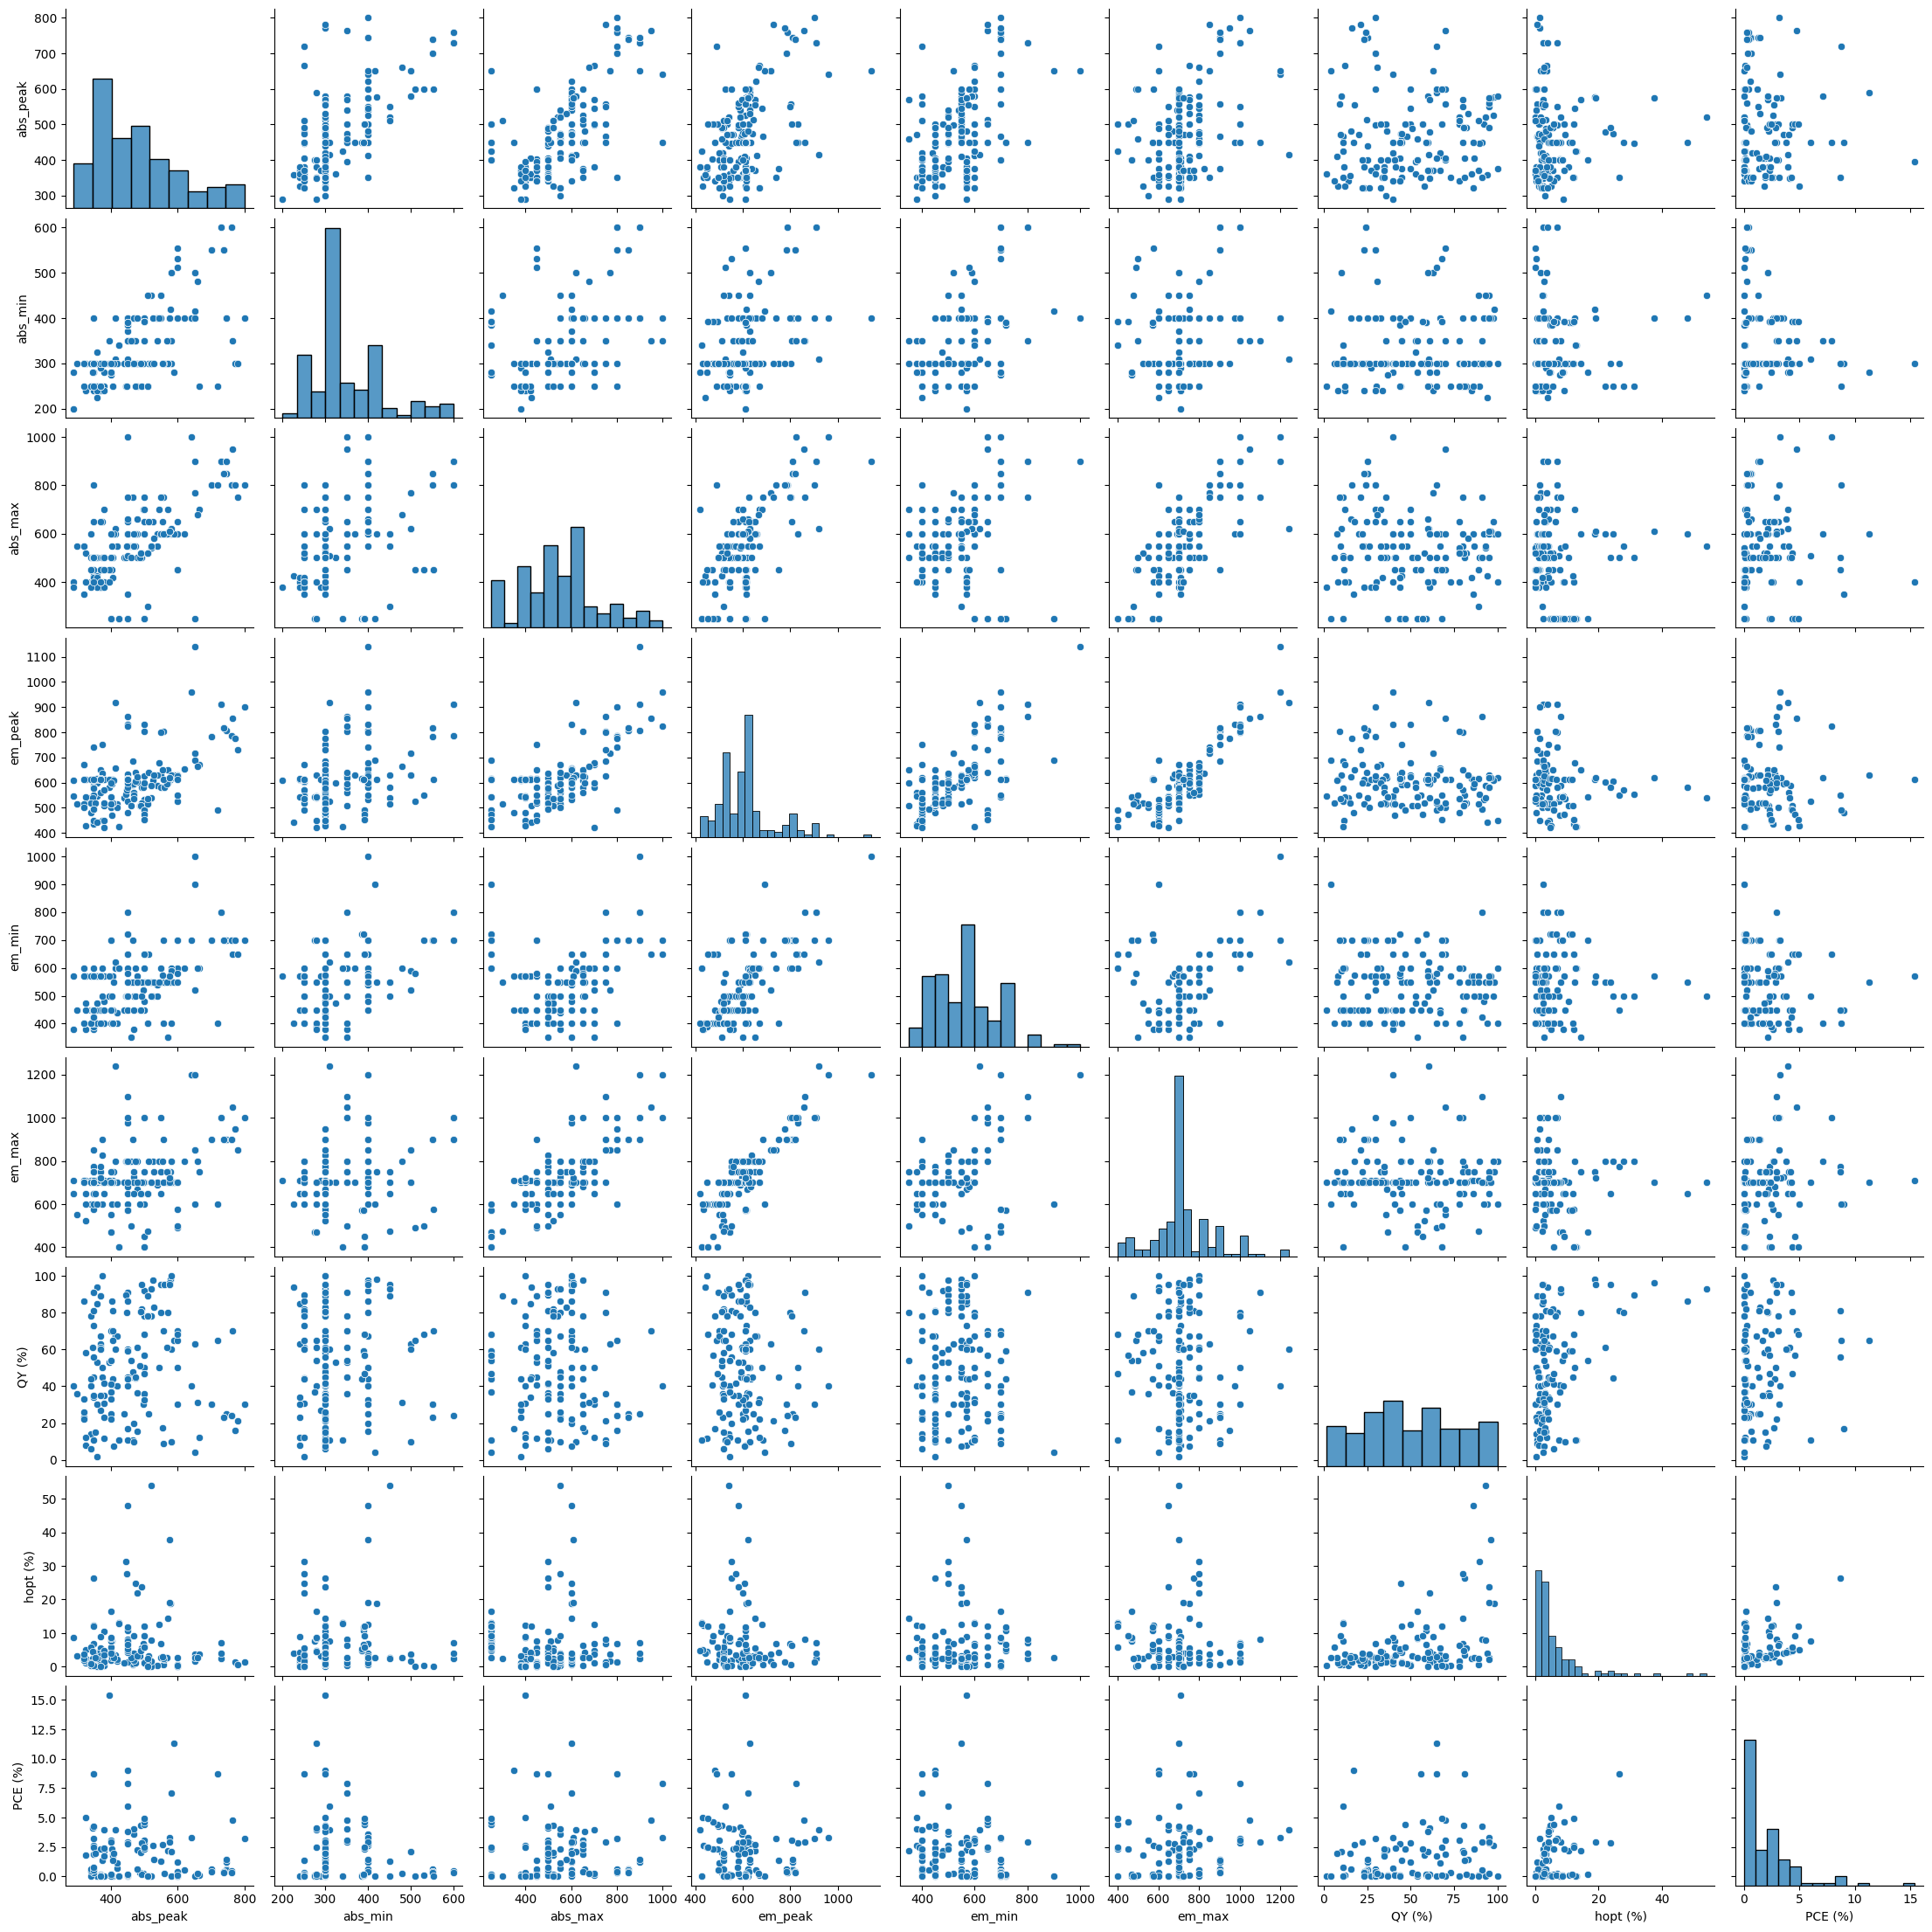

In [3]:
sns.pairplot(df.to_pandas())
plt.show()

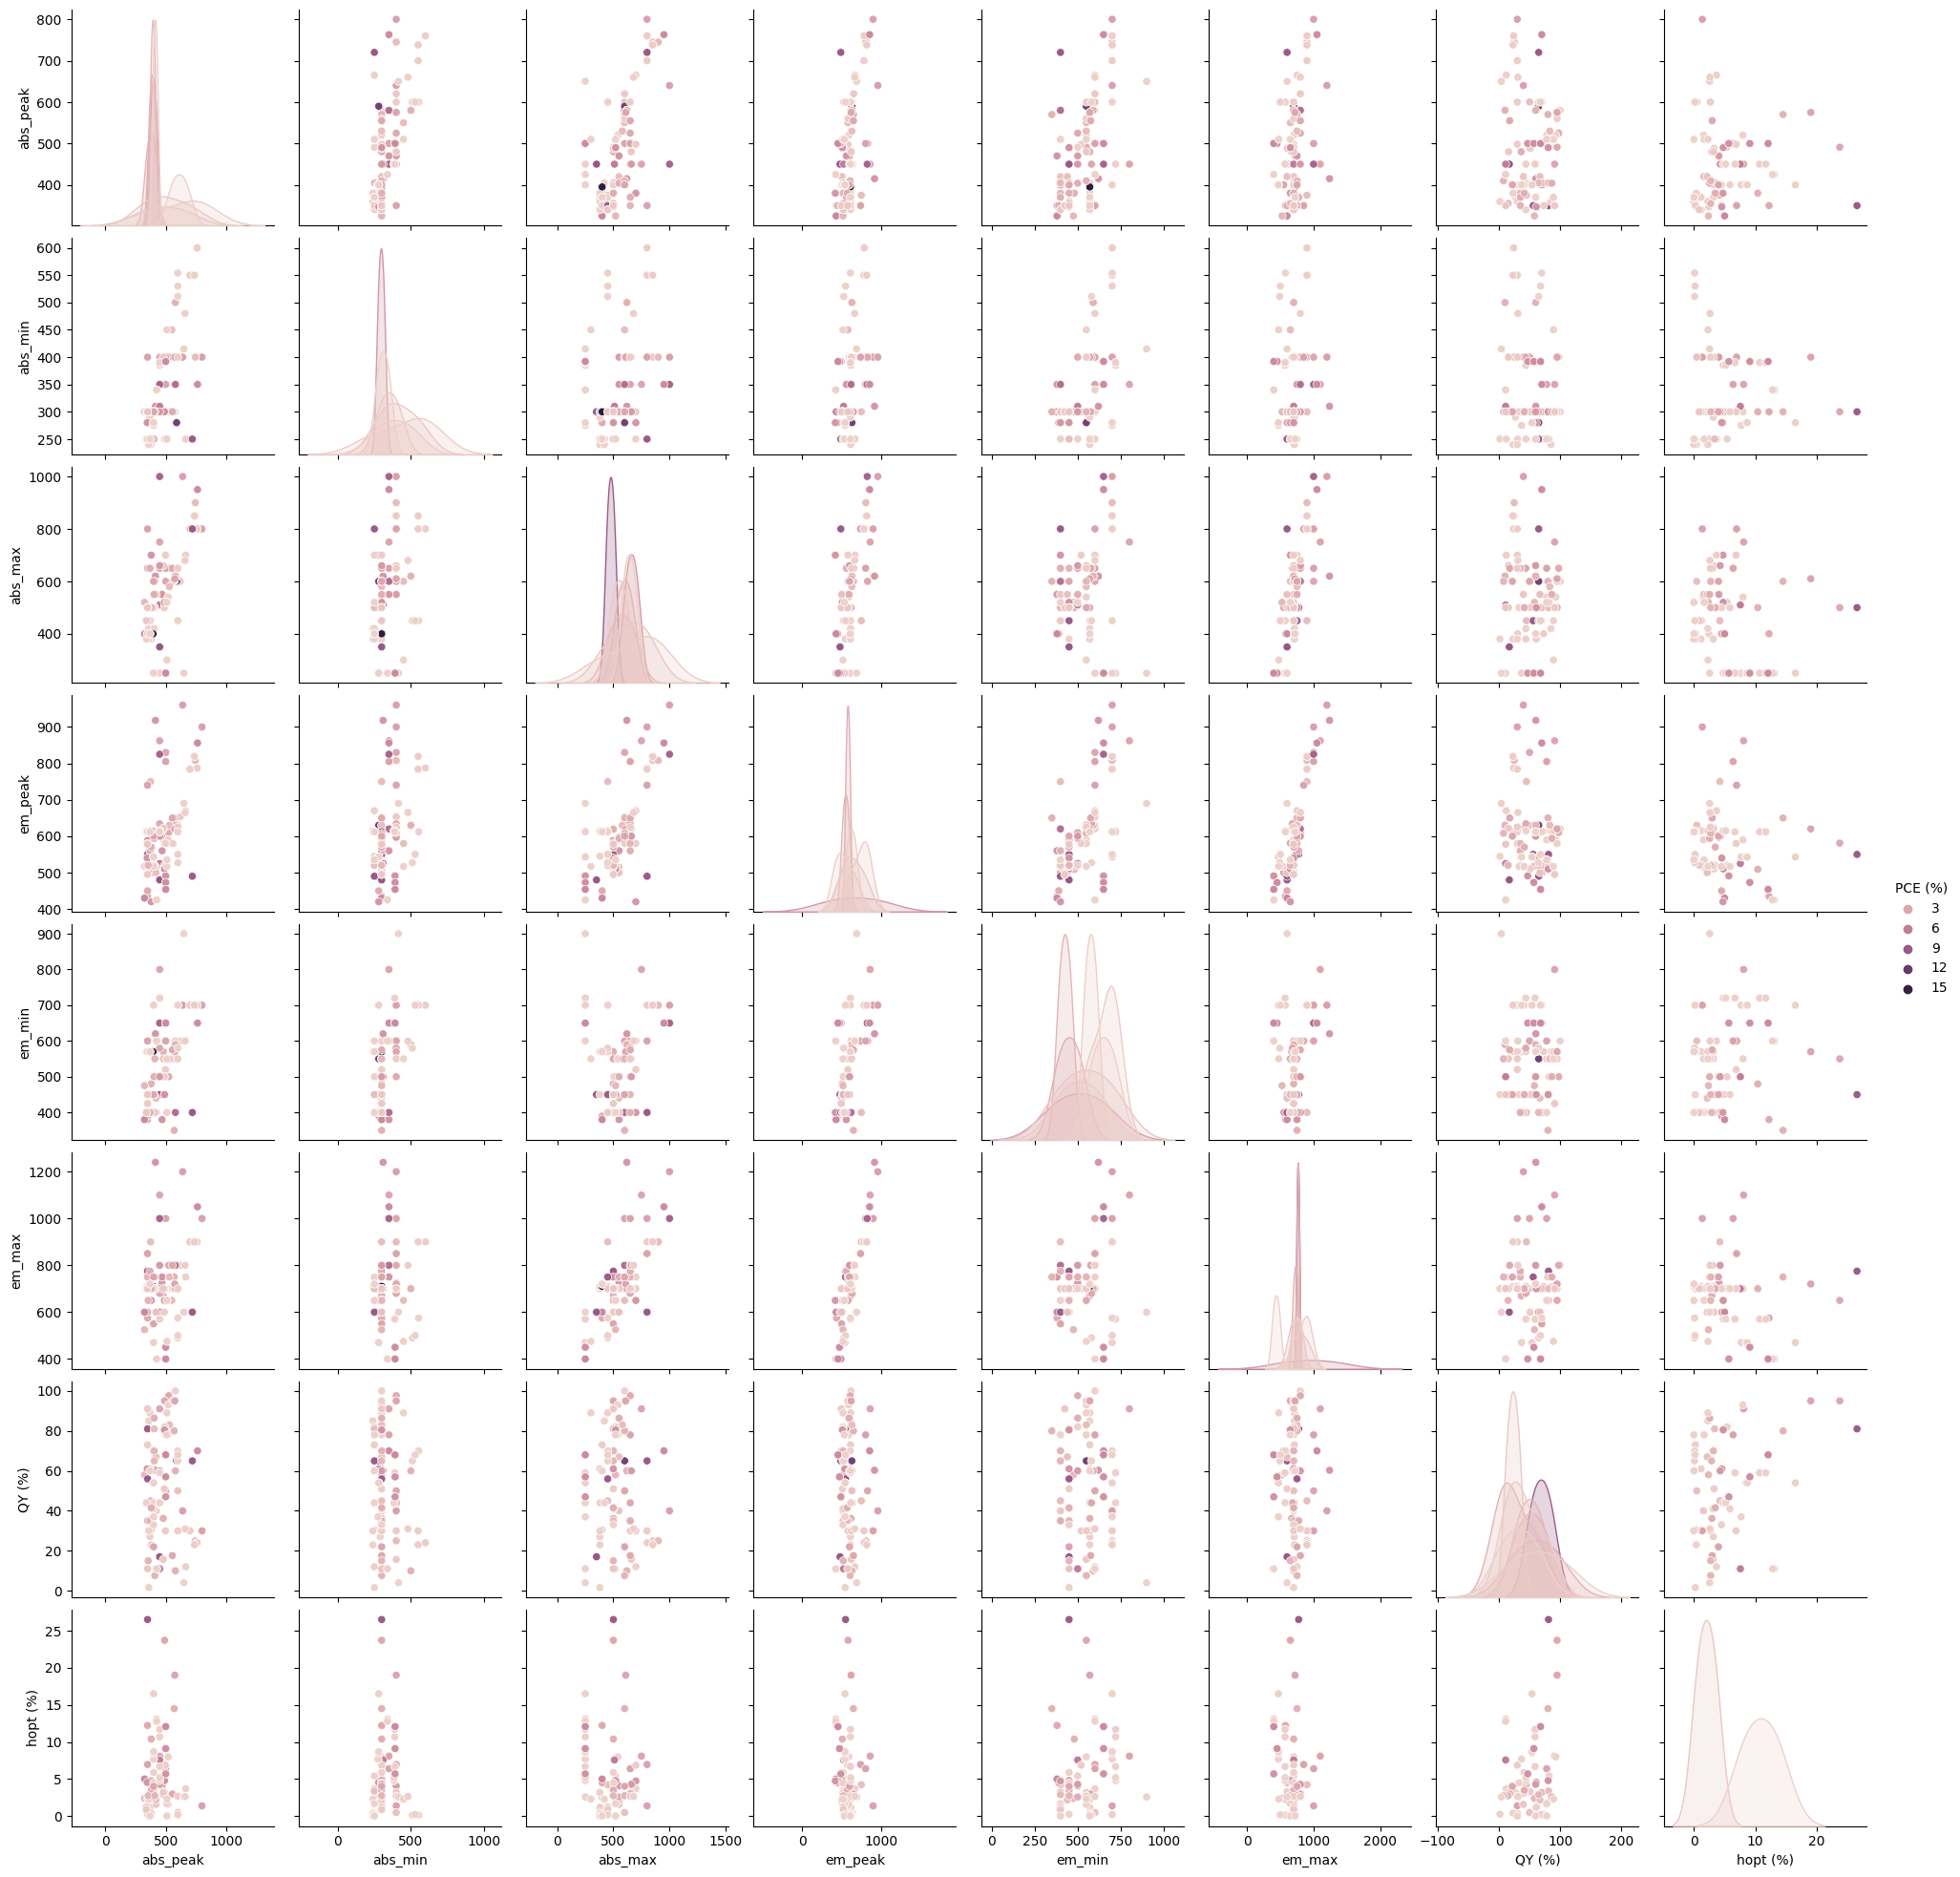

In [4]:
sns.pairplot(df.to_pandas(), hue='PCE (%)')
plt.show()

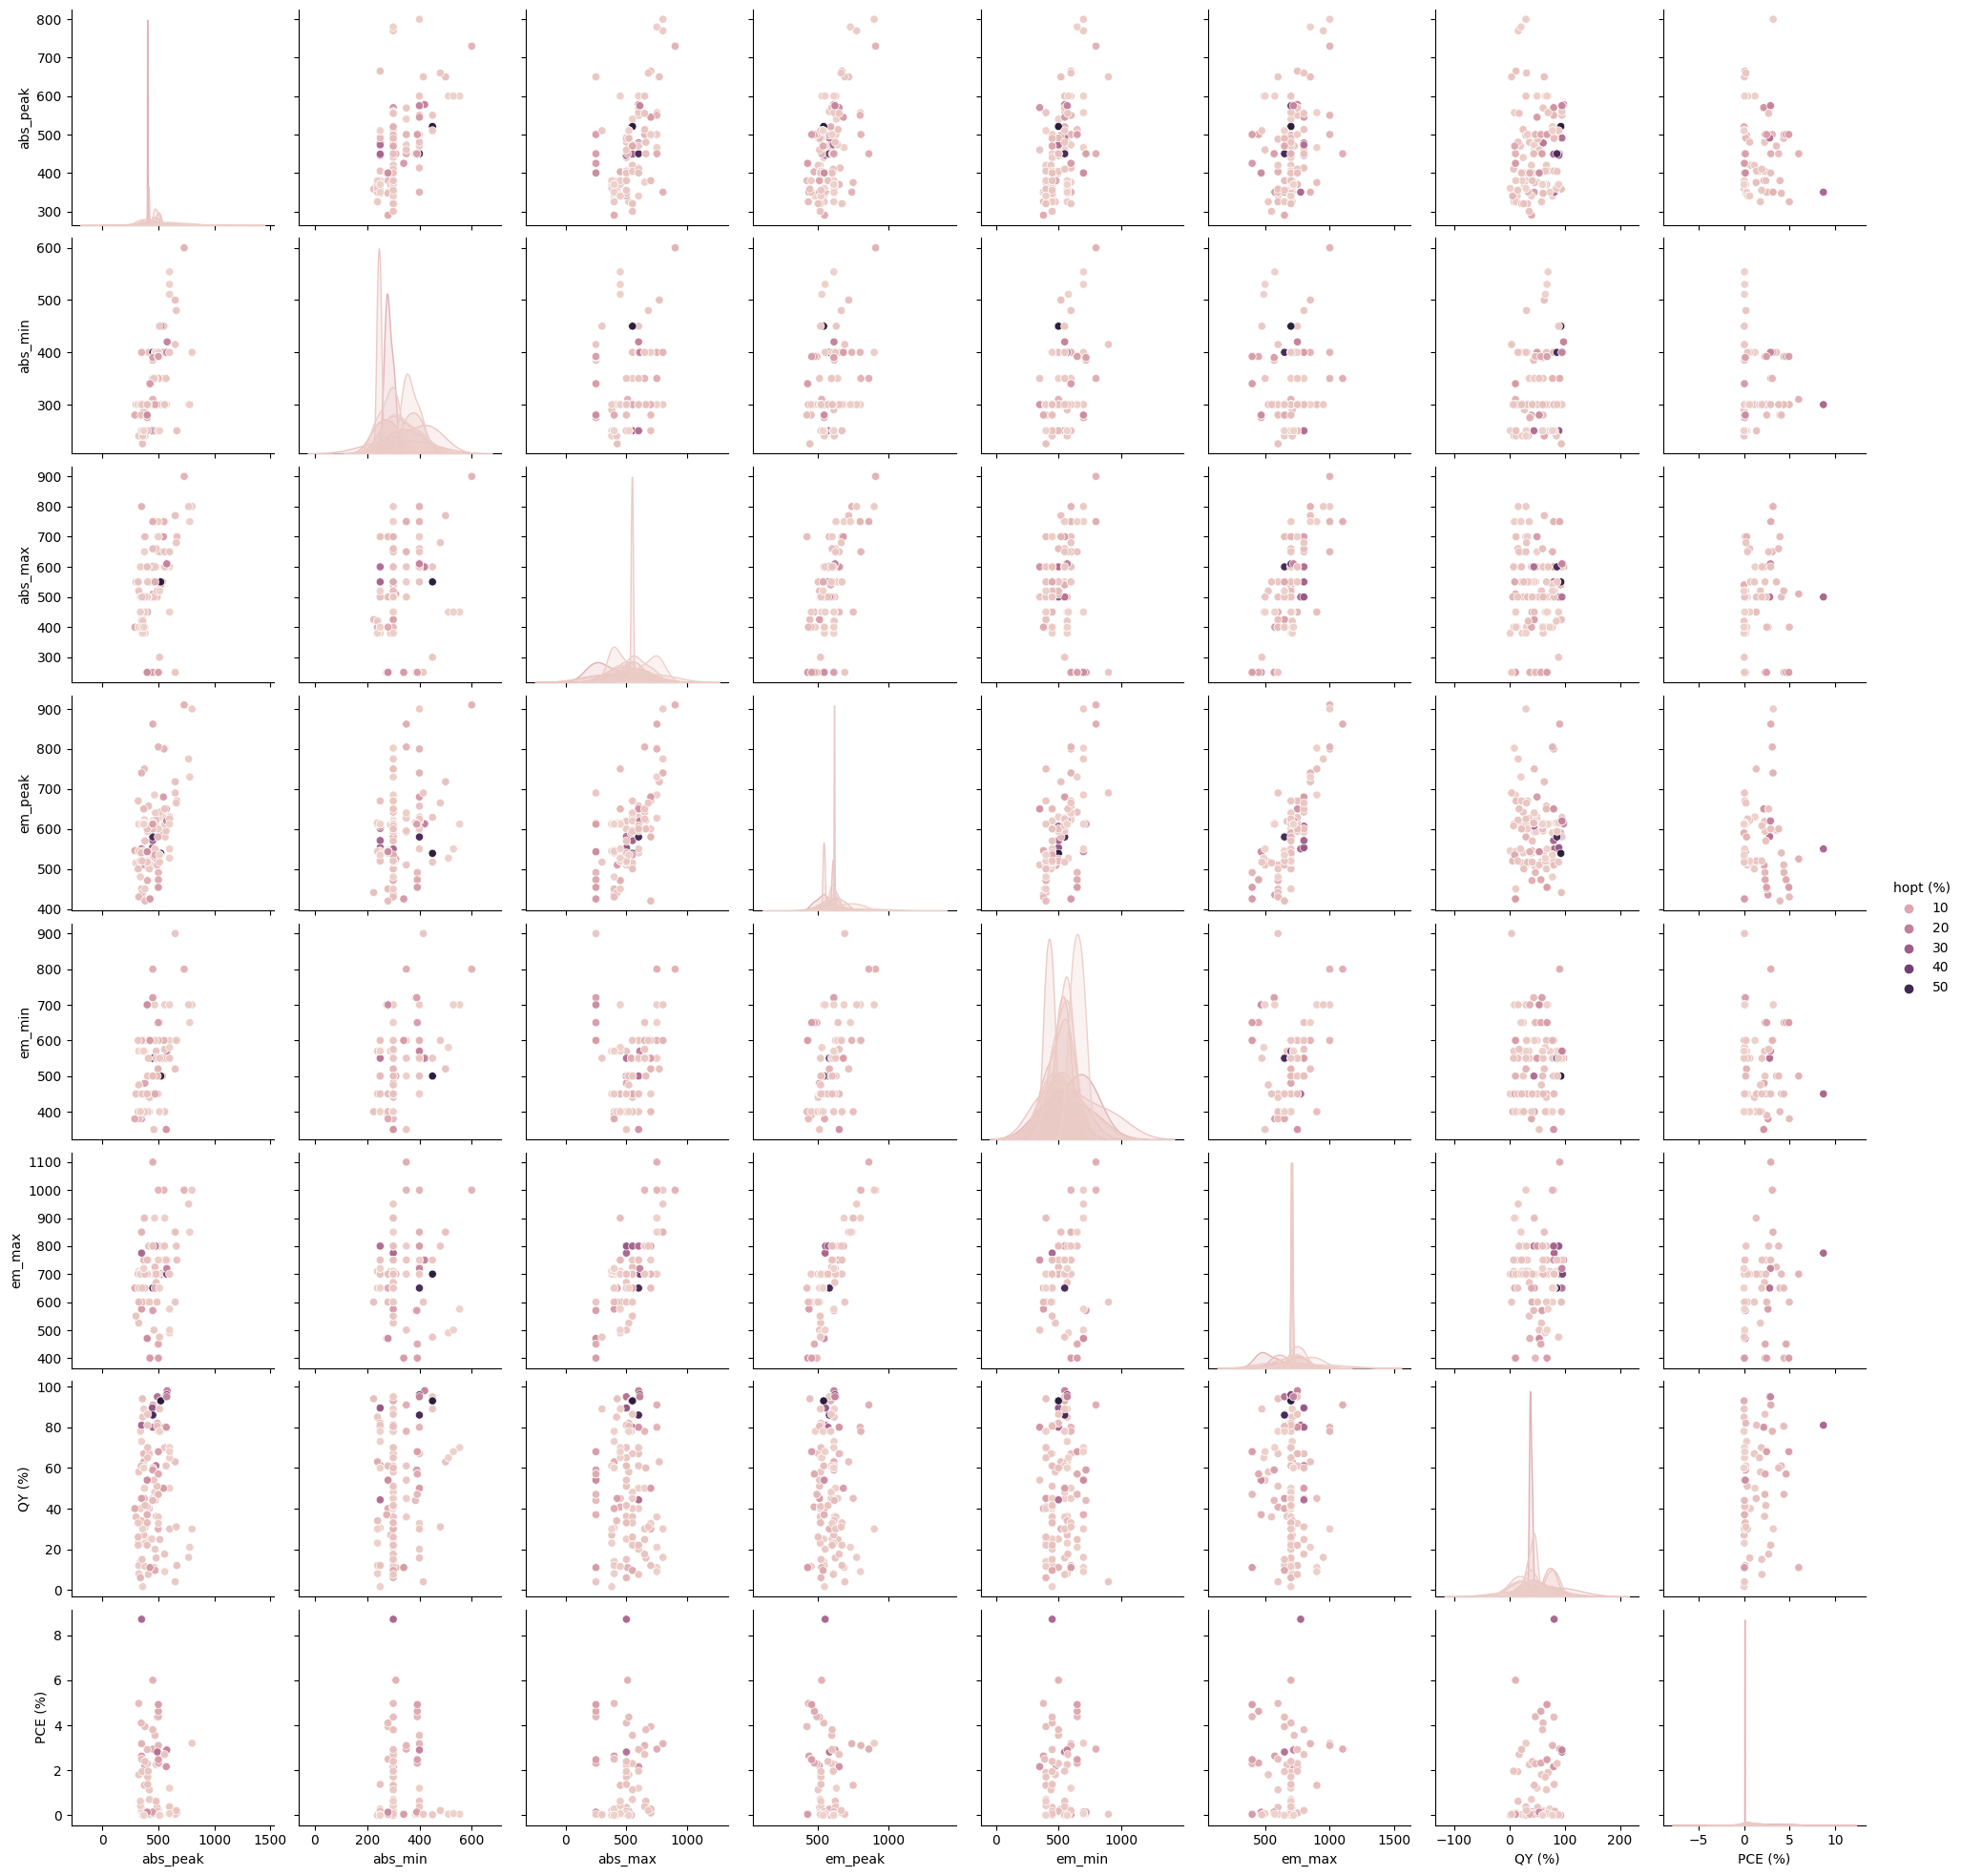

In [5]:
sns.pairplot(df.to_pandas(), hue='hopt (%)')
plt.show()

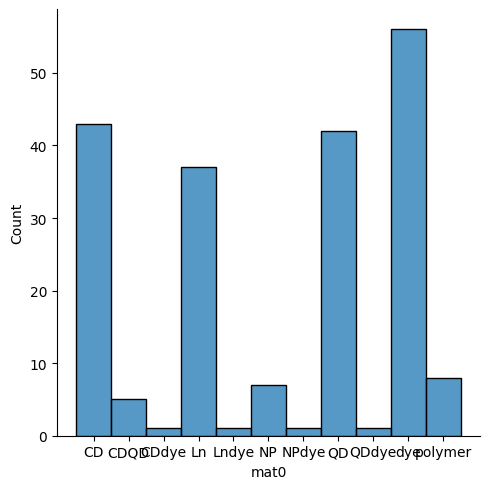

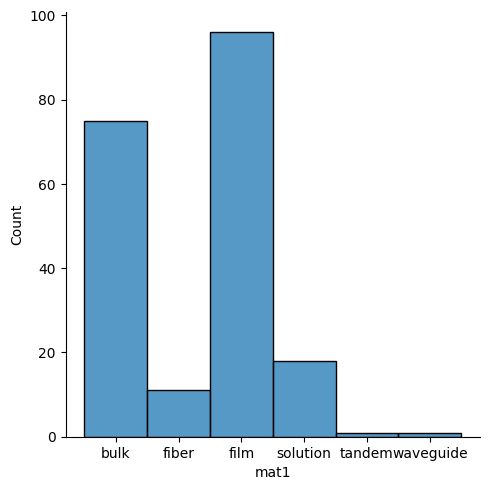

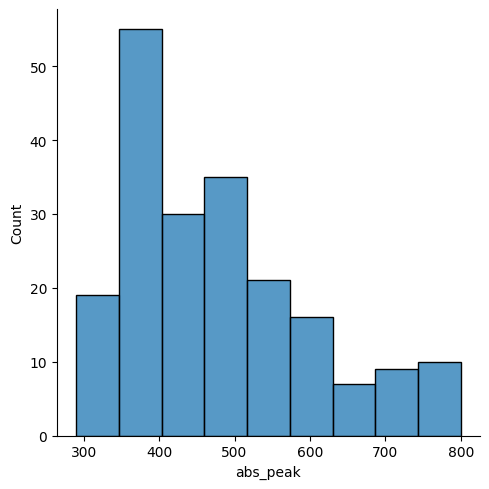

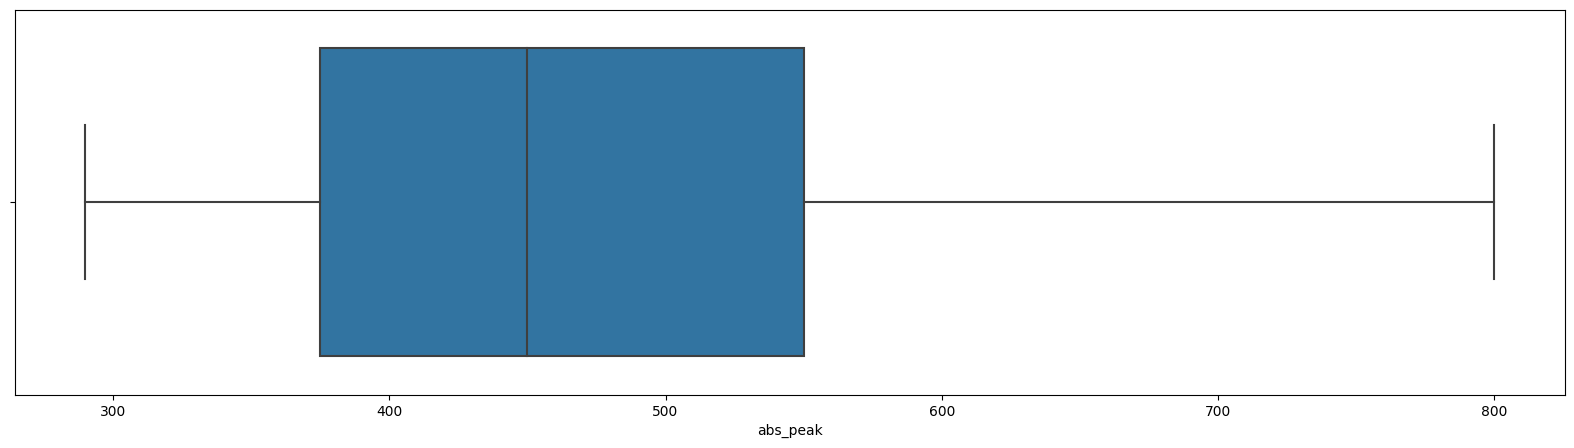

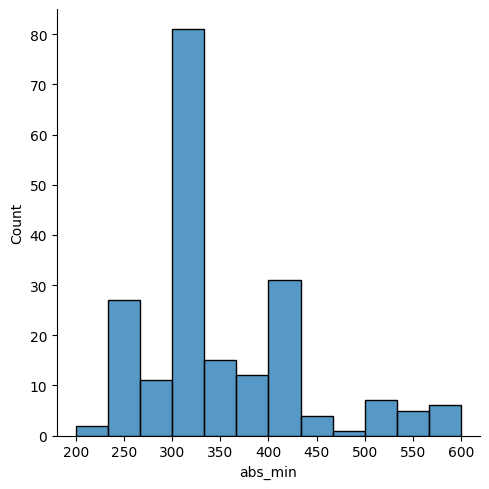

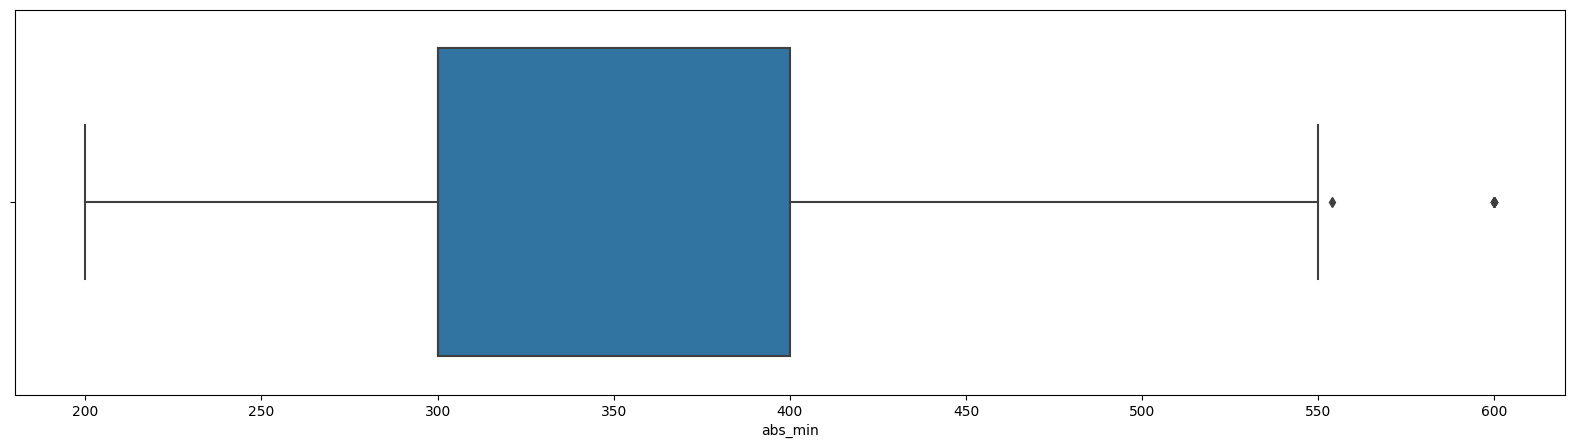

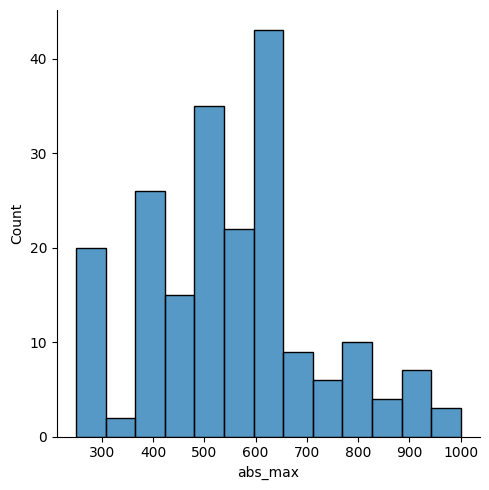

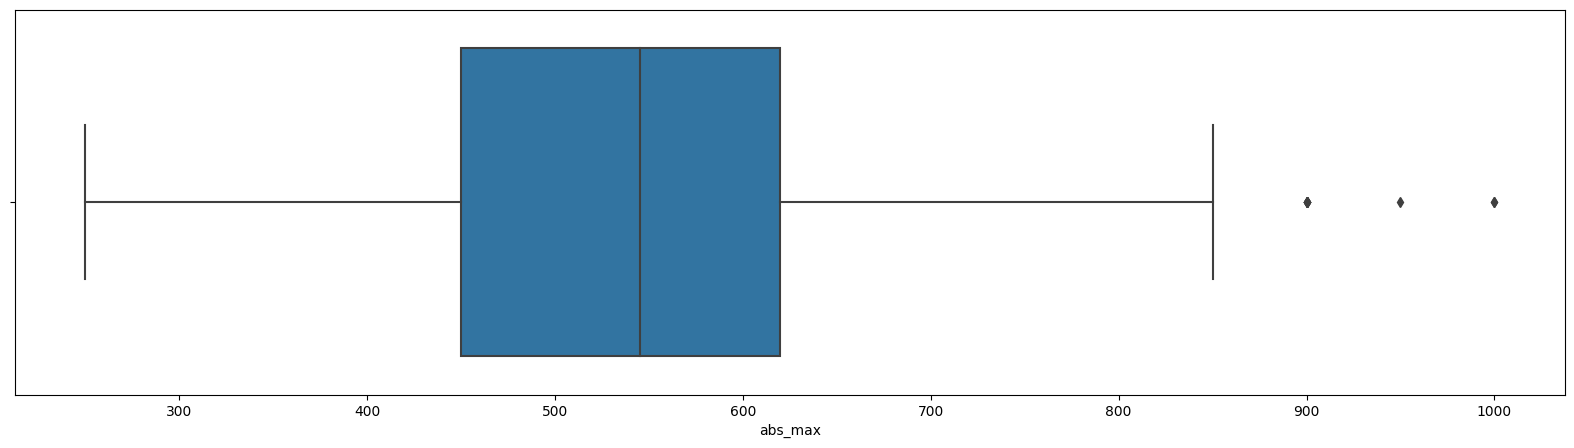

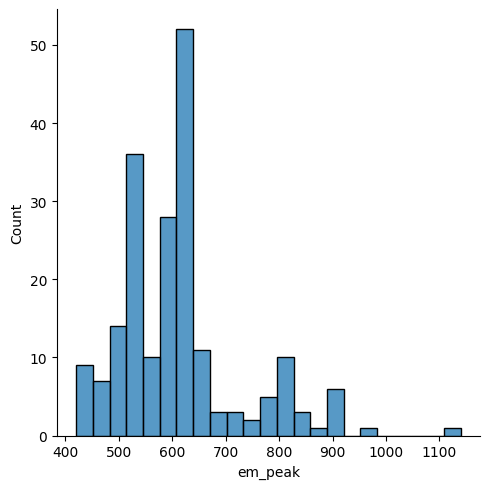

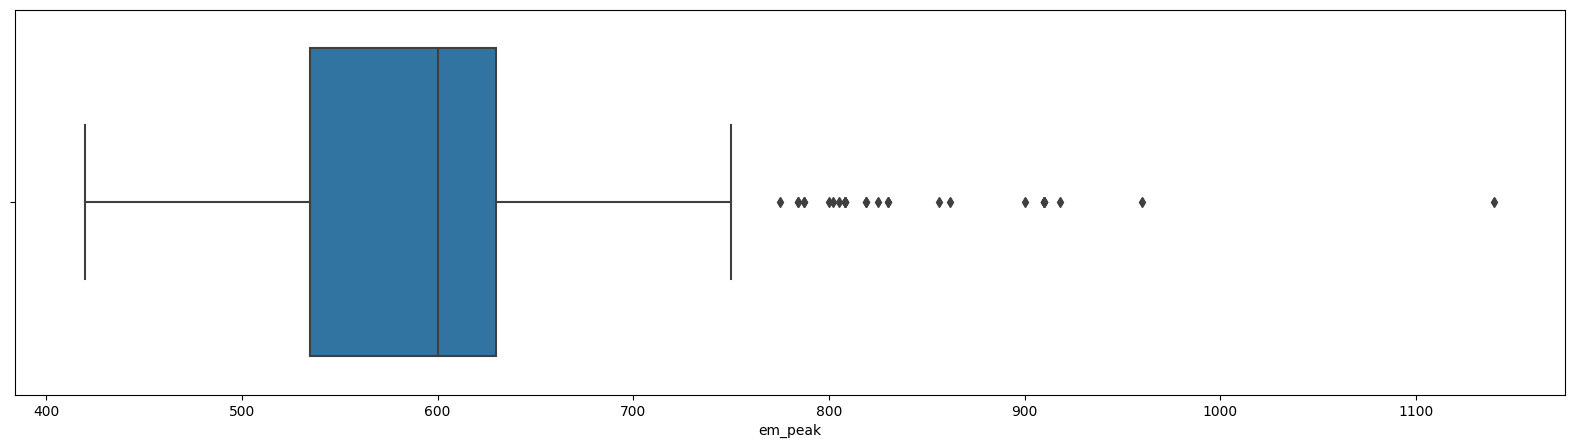

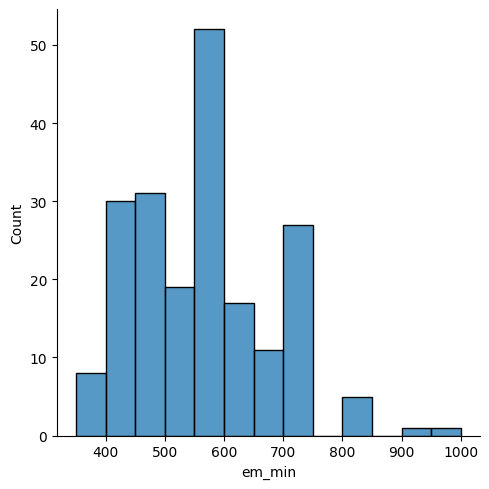

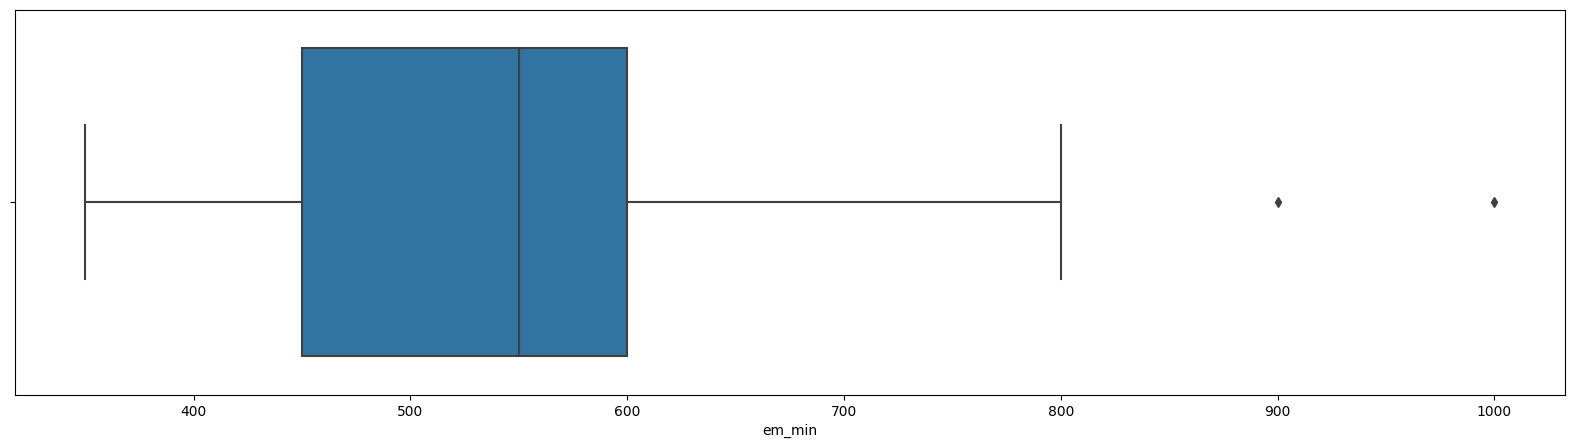

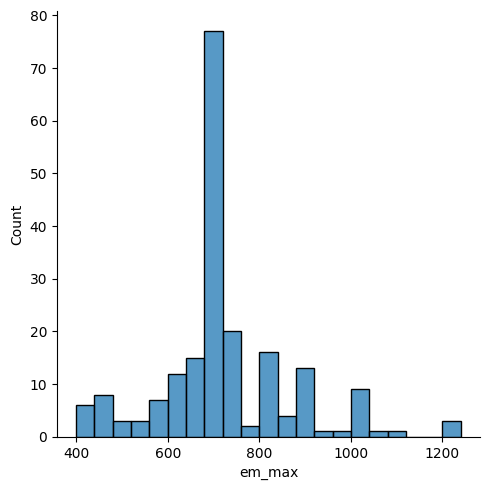

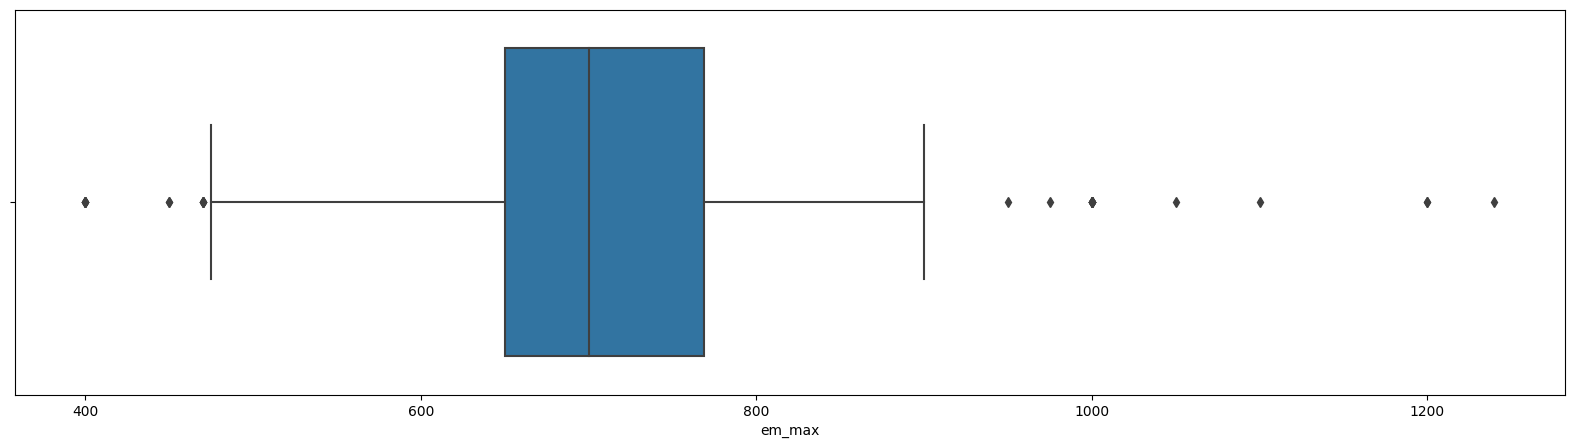

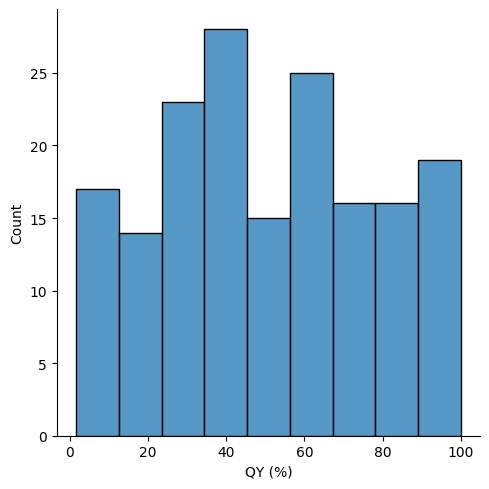

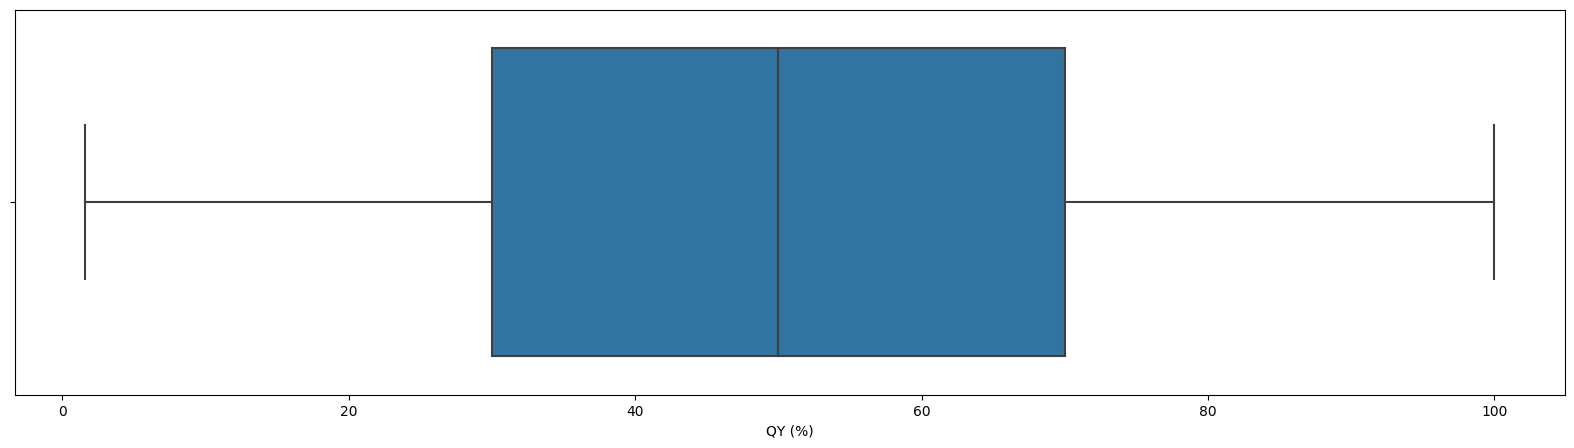

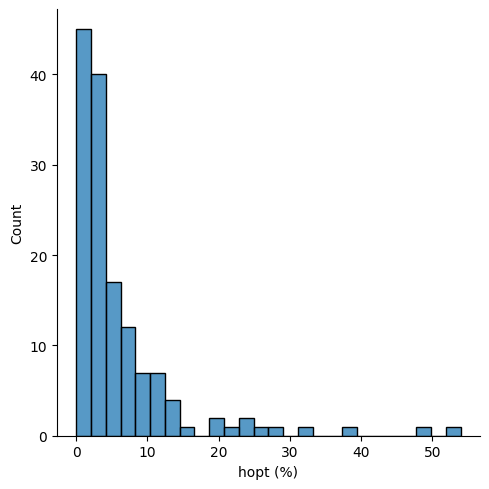

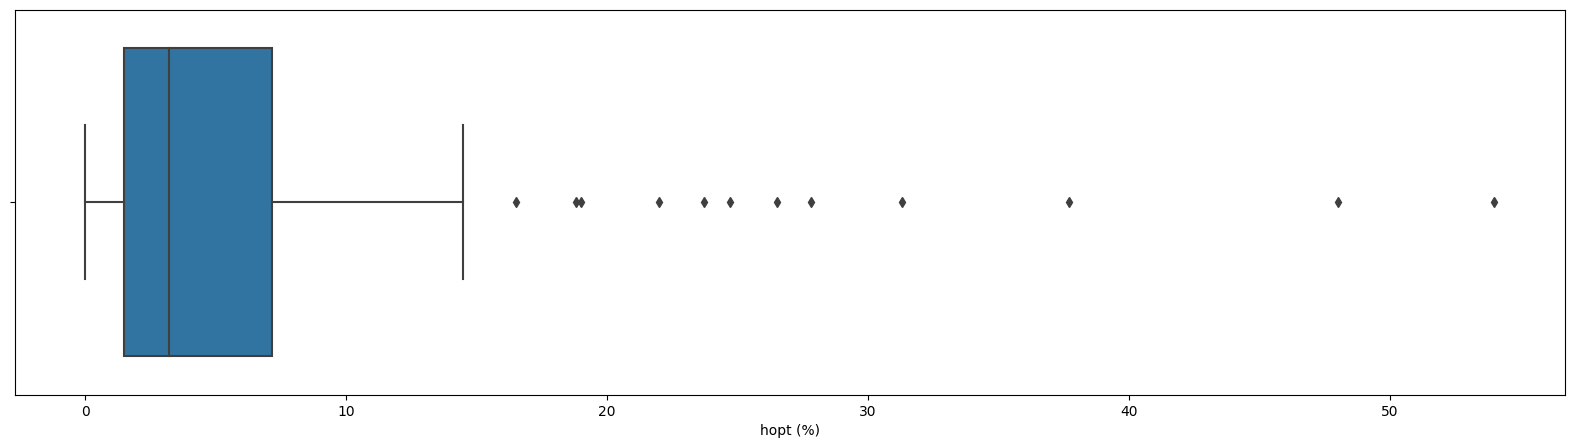

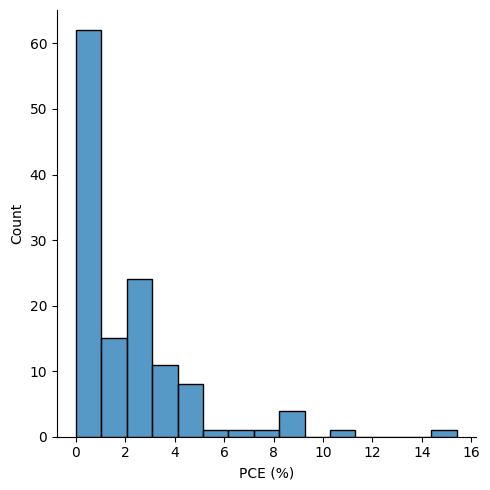

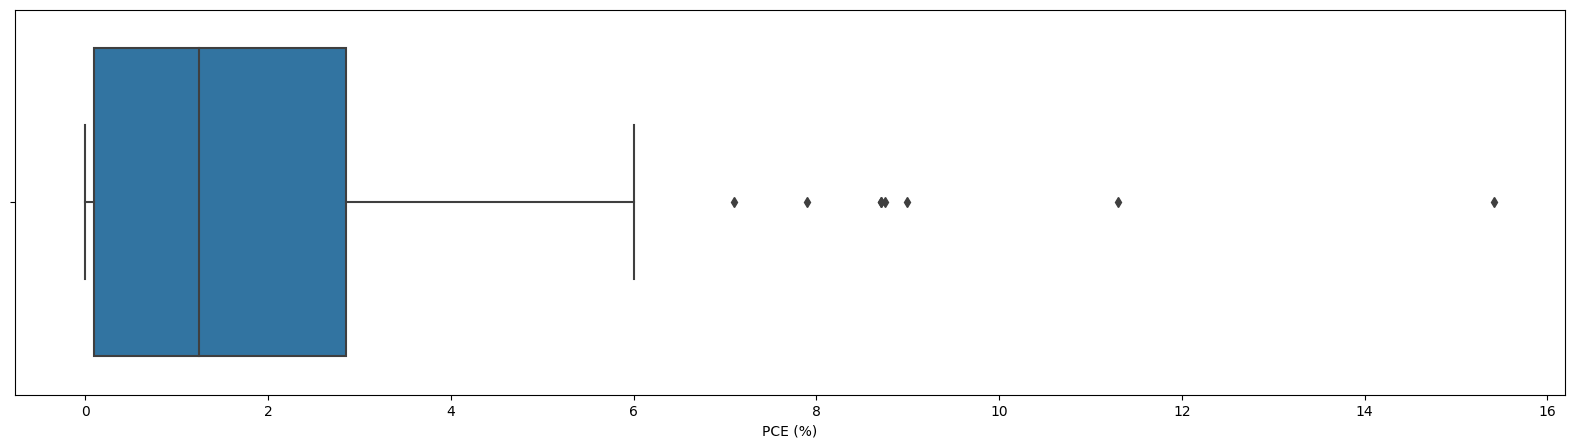

In [6]:
df_pandas = df.to_pandas()

categories = ['mat0', 'mat1']

for col in categories:
    df_pandas[col] = df_pandas[col].astype('category')

for col in df.get_columns():
    #print(f'{col.name}')
    sns.displot(data=df_pandas, x=col.name)
    plt.show()
    if col.name not in categories:
        sns.boxplot(data=df_pandas, x=col.name)
        plt.show()

In [7]:
total, _ = df.shape
for col in df.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 14%
hopt (%): 29%
PCE (%): 36%


## PCE and hopt prediction

### Baseline (using only abs and em)

In [8]:
df_baseline_PCE = df.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)'])
df_baseline_PCE = df_baseline_PCE.drop_nulls()

total, _ = df_baseline_PCE.shape
for col in df_baseline_PCE.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_baseline_PCE.shape

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


shape: (129, 7)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ PCE (%)  │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---      │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪══════════╡
│ 800      ┆ 400     ┆ 800     ┆ 900     ┆ 700    ┆ 1000   ┆ 3.2      │
│ 600      ┆ 400     ┆ 600     ┆ 630     ┆ 600    ┆ 700    ┆ 1.2      │
│ 550      ┆ 450     ┆ 600     ┆ 580     ┆ 550    ┆ 650    ┆ 1.3      │
│ 470      ┆ 400     ┆ 550     ┆ 597     ┆ 500    ┆ 725    ┆ 3.55     │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...      │
│ 660      ┆ 480     ┆ 680     ┆ 665     ┆ 600    ┆ 800    ┆ 0.21     │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 0.000198 │
│ 510      ┆ 250     ┆ 520     ┆ 535     ┆ 400    ┆ 650    ┆ 0.000182 │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 0.000471 │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴──────────┘

In [9]:
df_baseline_hopt = df.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)'])
df_baseline_hopt = df_baseline_hopt.drop_nulls()

total, _ = df_baseline_hopt.shape
for col in df_baseline_hopt.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_baseline_hopt

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


shape: (144, 7)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ hopt (%) │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---      │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪══════════╡
│ 578      ┆ 420     ┆ 600     ┆ 613     ┆ 550    ┆ 750    ┆ 18.8     │
│ 730      ┆ 600     ┆ 900     ┆ 910     ┆ 800    ┆ 1000   ┆ 2.5      │
│ 730      ┆ 600     ┆ 900     ┆ 910     ┆ 800    ┆ 1000   ┆ 2.5      │
│ 730      ┆ 600     ┆ 900     ┆ 910     ┆ 800    ┆ 1000   ┆ 4.0      │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...      │
│ 660      ┆ 480     ┆ 680     ┆ 665     ┆ 600    ┆ 800    ┆ 2.65     │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 0.02     │
│ 510      ┆ 250     ┆ 520     ┆ 535     ┆ 400    ┆ 650    ┆ 0.035    │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 0.048    │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴──────────┘

In [10]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)

models = [('Linear Regression', LinearRegression(), {}),
          ('K Neighbors Regressor', KNeighborsRegressor(),
           {'n_neighbors':[1,3,5,7,9], 'weights':['uniform', 'distance'], 'p':[1,2]}),
          ('Lasso Regression', Lasso(max_iter=5000, tol=1E-3, random_state=42),
           {'alpha': (np.logspace(-8, 8, 20))}),
          ('Support Vector Regressor', SVR(kernel='linear'),
           {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01],'kernel': ['rbf', 'sigmoid']}),
          ('Random Forest Regressor', RandomForestRegressor(random_state=42),
           {'n_estimators':[50,100,150], 'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4],
            'bootstrap':[True, False], 'max_depth':max_depth}),
          ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42),
           {'n_estimators':[50, 100, 150],'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4],'max_depth':max_depth})]

#('ANN', MLPRegressor(max_iter=50000,  tol=1E-3, random_state=42),{'hidden_layer_sizes':[(8,), (16,), (32,)],'activation':['relu','logistic'], 'learning_rate':['constant', 'invscaling', 'adaptive']}),

In [14]:
def compute_performance(models, X, y):
    best_models = []
    for m in models:
        clf = GridSearchCV(m[1], m[2], cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
        clf.fit(X, y)
        scores = -1 * clf.best_score_
        print(f'{m[0]:30}: {scores.mean()}')
        best_models.append(clf.best_estimator_)
    print()

    for i in range(len(models)):
        model = best_models[i]
        y_pred = cross_val_predict(model, X, y, cv=10)
        print(f'{models[i][0]:30}')
        fig = sns.kdeplot(y, fill=True, color="r")
        fig = sns.kdeplot(y_pred, fill=True, color="b")
        plt.show()

PCE
Linear Regression             : 1.8546476490255437
K Neighbors Regressor         : 1.6312754572434838
Lasso Regression              : 1.8206420622361343
Support Vector Regressor      : 1.6590574649220167
ANN                           : 1.7736535696795426
Random Forest Regressor       : 1.698489279610738
Gradient Boosting Regressor   : 1.7115018984173762

Linear Regression             


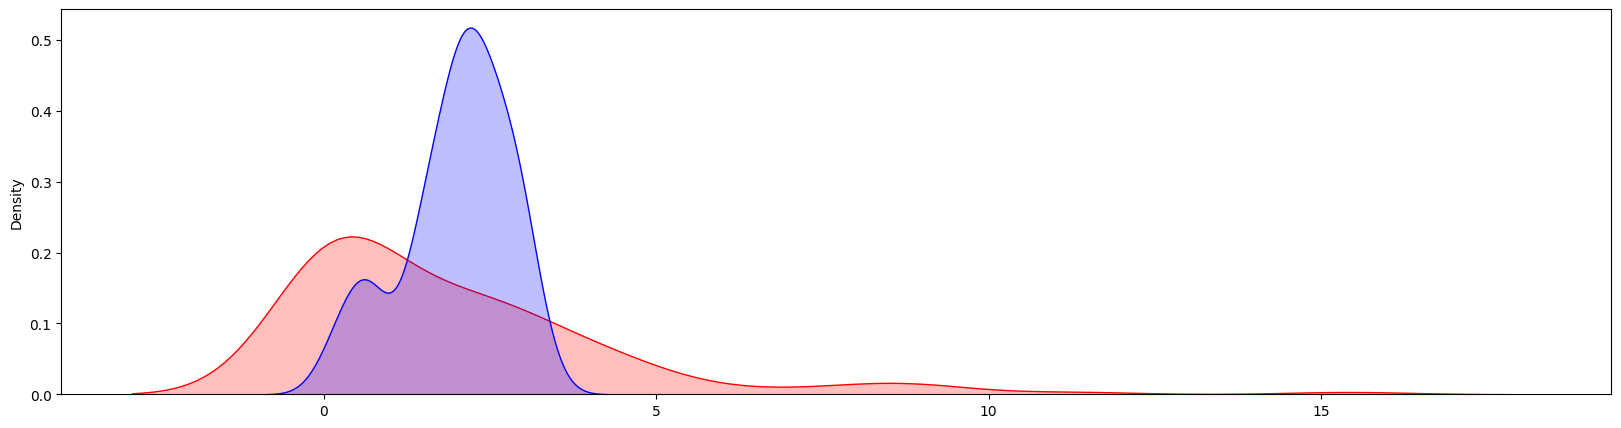

K Neighbors Regressor         


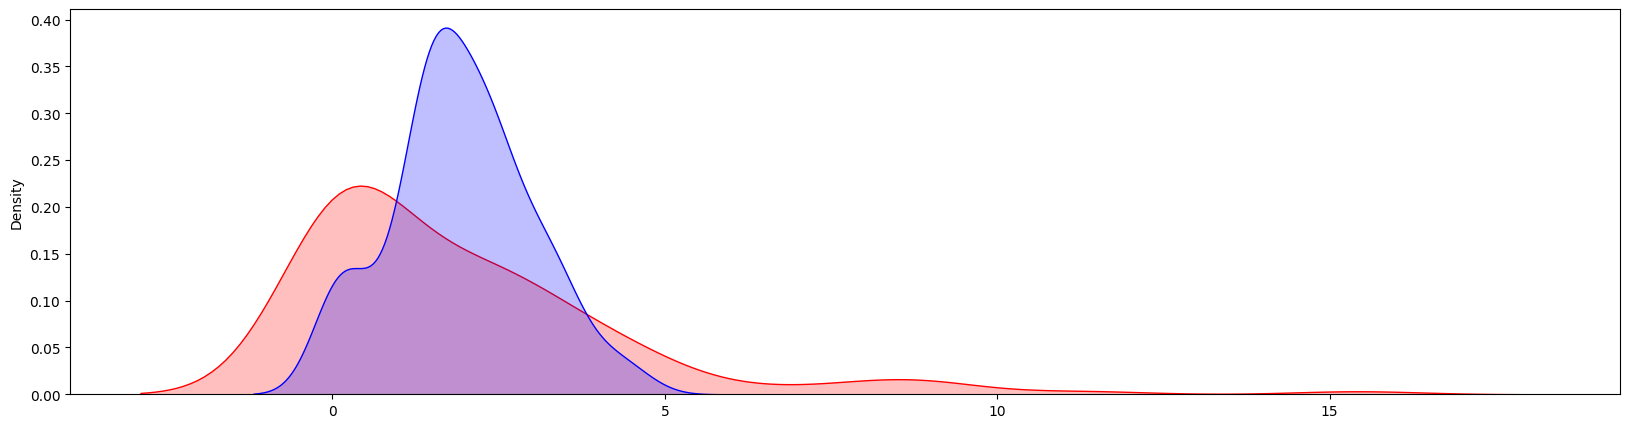

Lasso Regression              


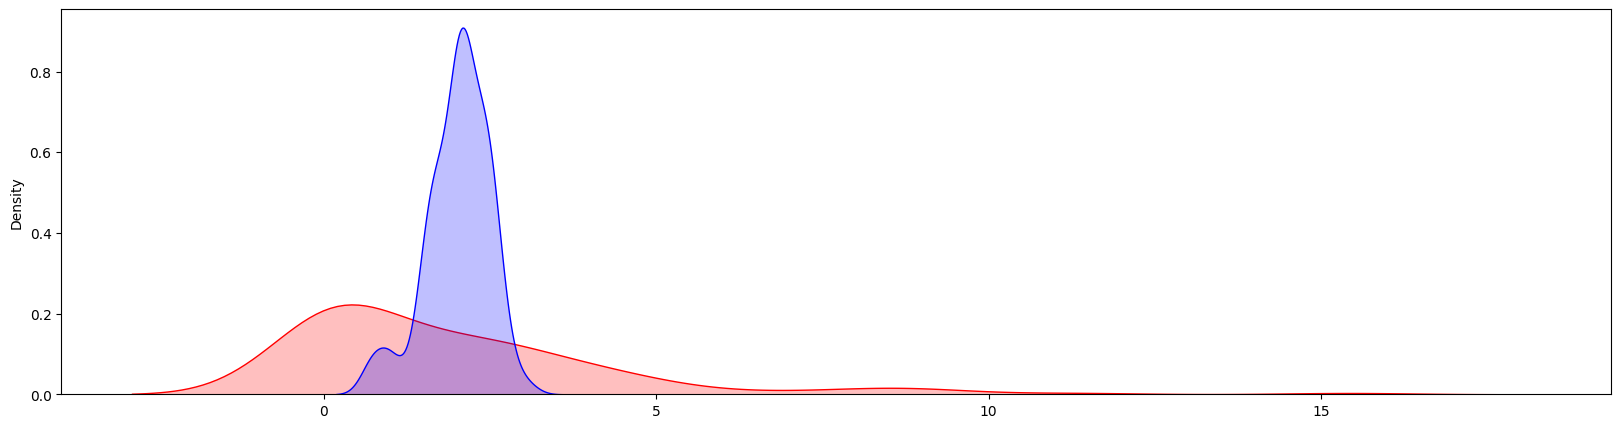

Support Vector Regressor      


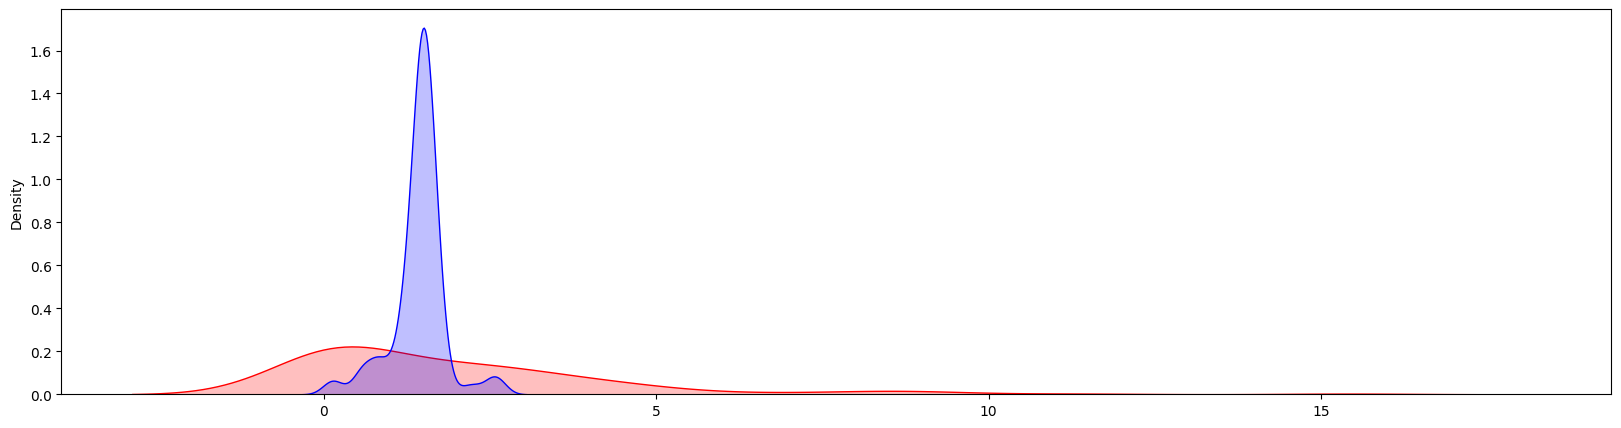

ANN                           


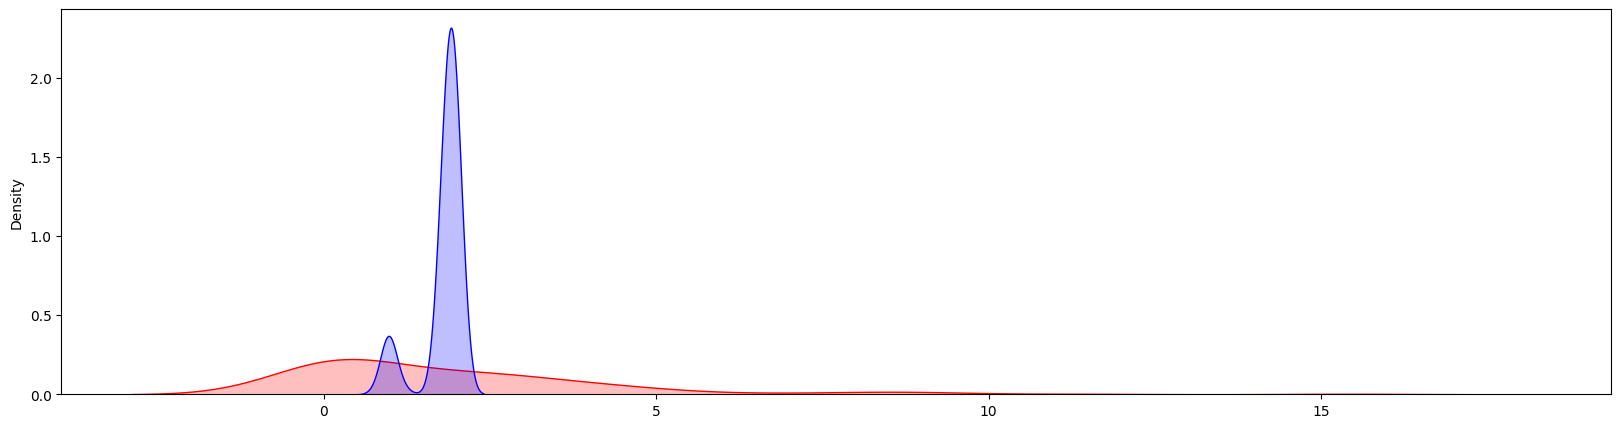

Random Forest Regressor       


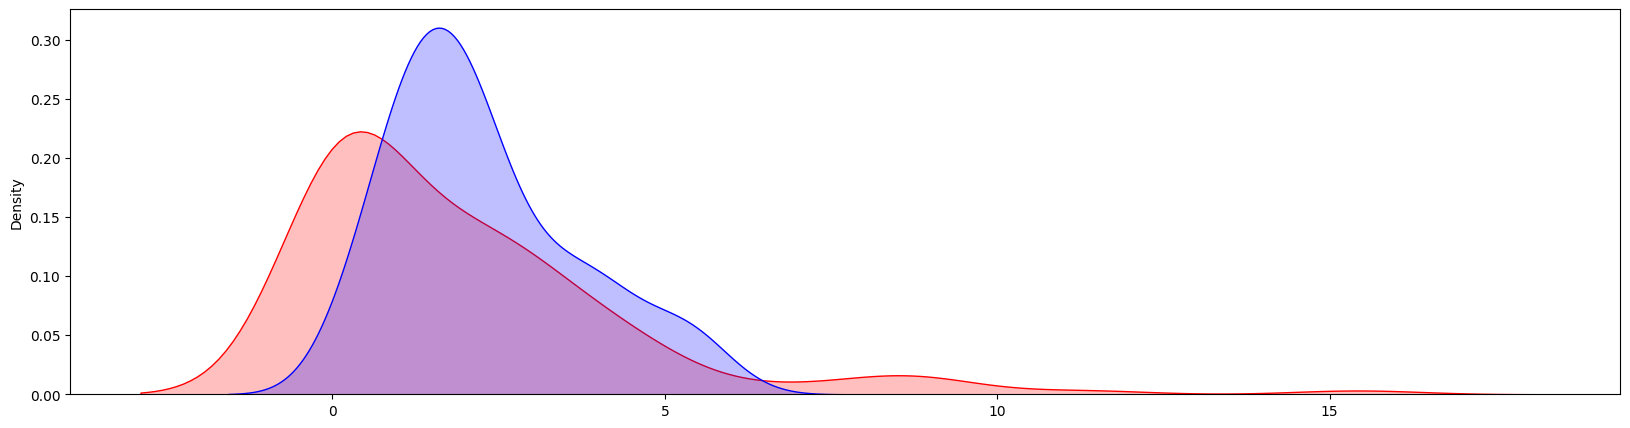

Gradient Boosting Regressor   


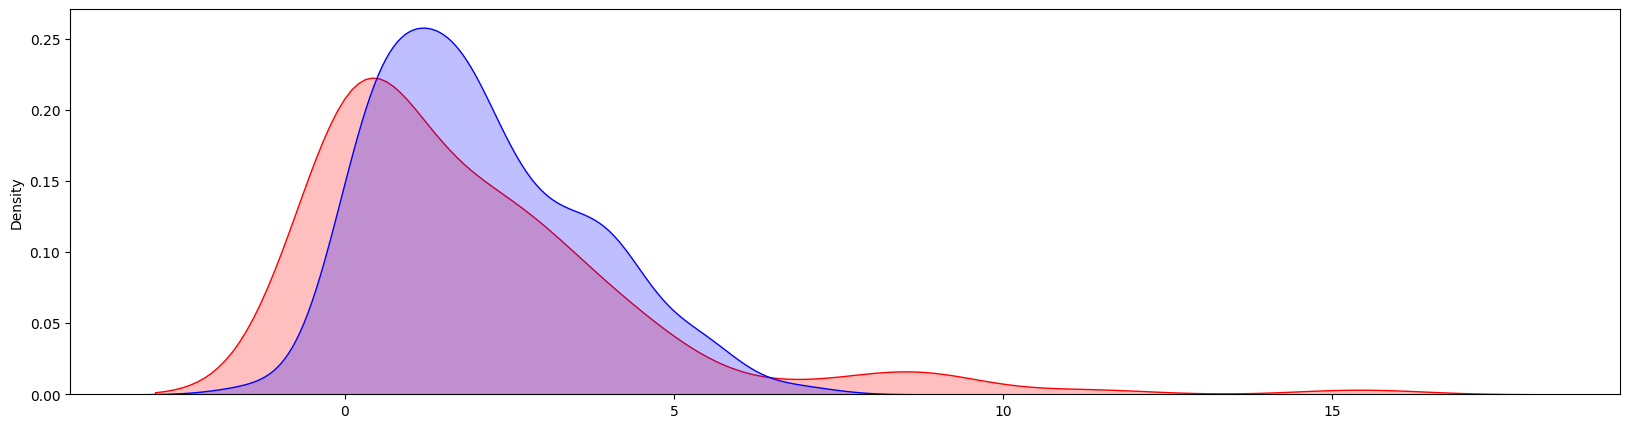

In [12]:
# Get Output variables
PCE = df_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
compute_performance(models, X, y_PCE)

hopt
Linear Regression             : 6.068799557927493
K Neighbors Regressor         : 4.842737729031478
Lasso Regression              : 5.3191056981003495
Support Vector Regressor      : 4.567340446793254
ANN                           : 5.181945254844541
Random Forest Regressor       : 5.424323966167668
Gradient Boosting Regressor   : 6.161826415711126

Linear Regression             


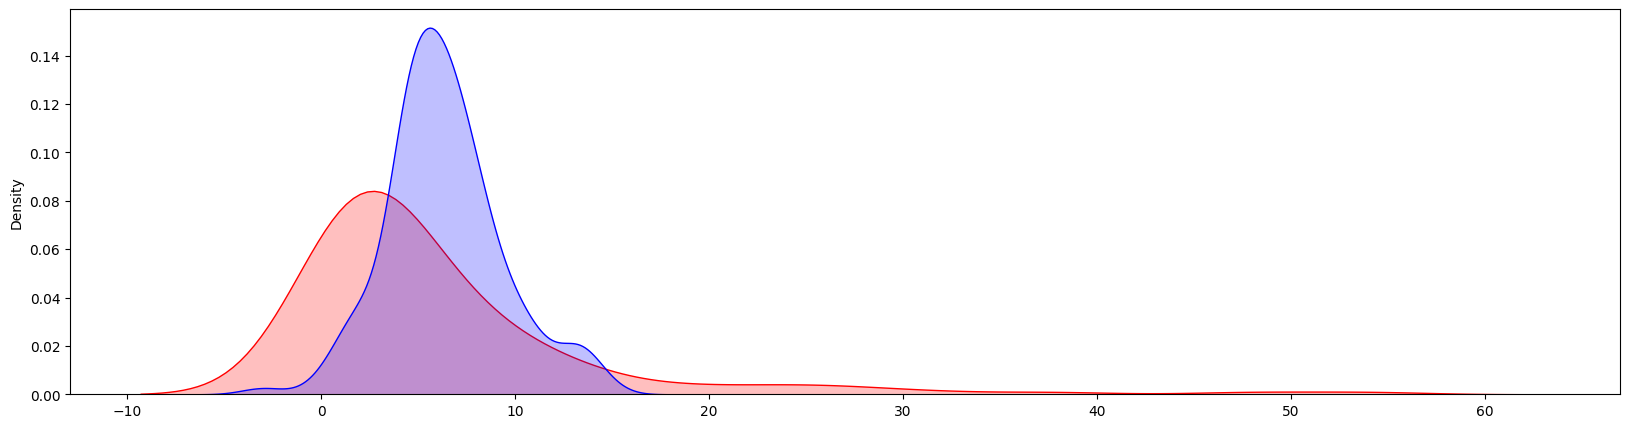

K Neighbors Regressor         


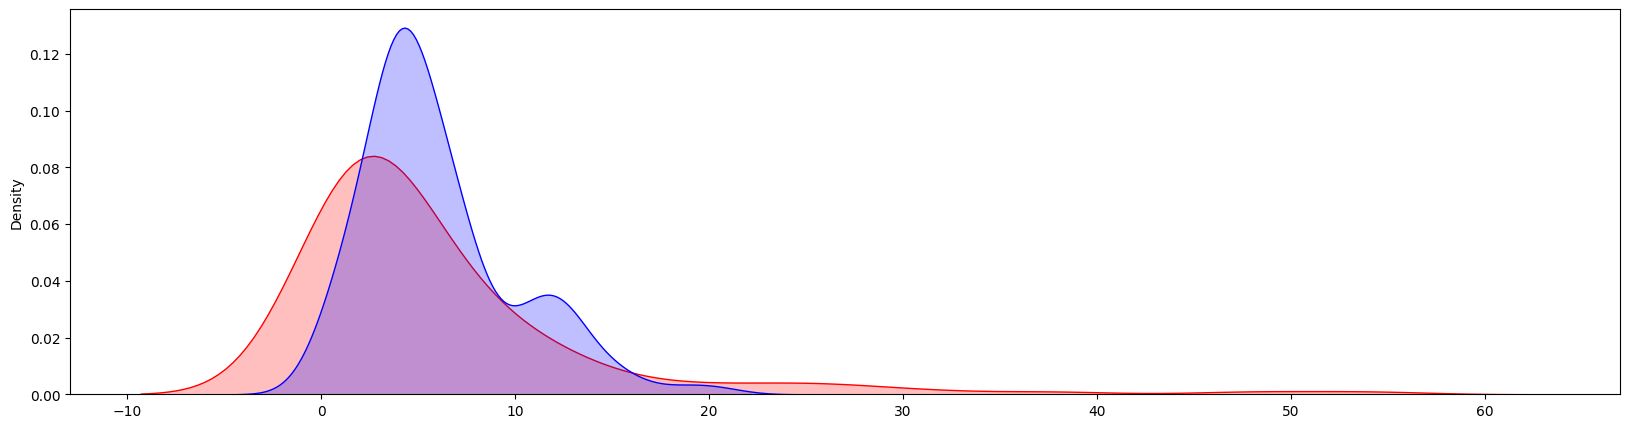

Lasso Regression              


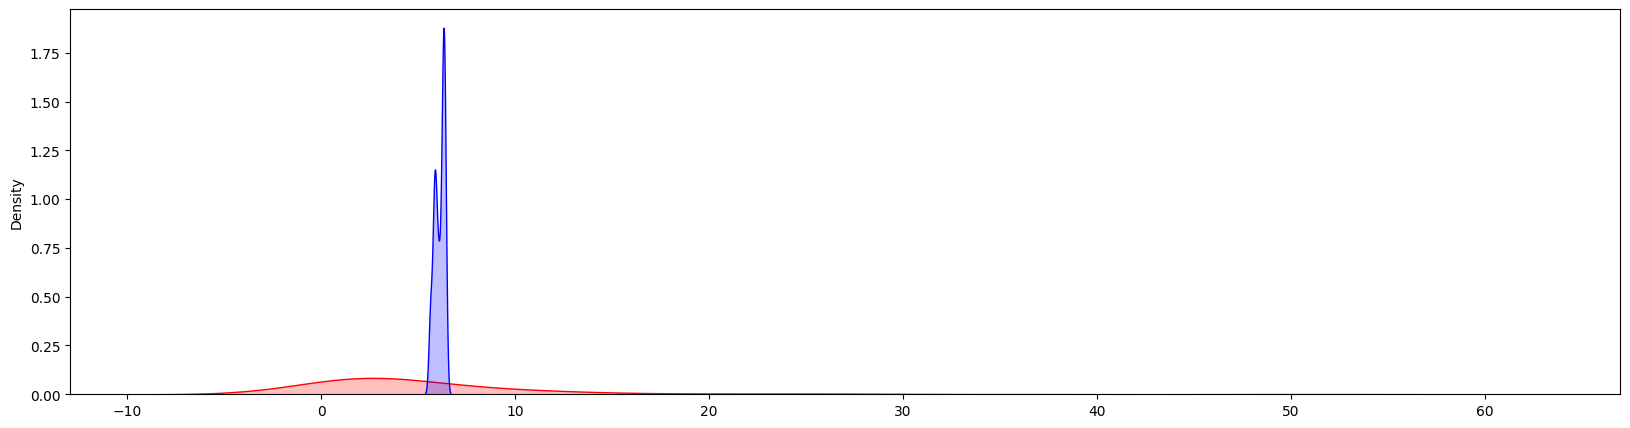

Support Vector Regressor      


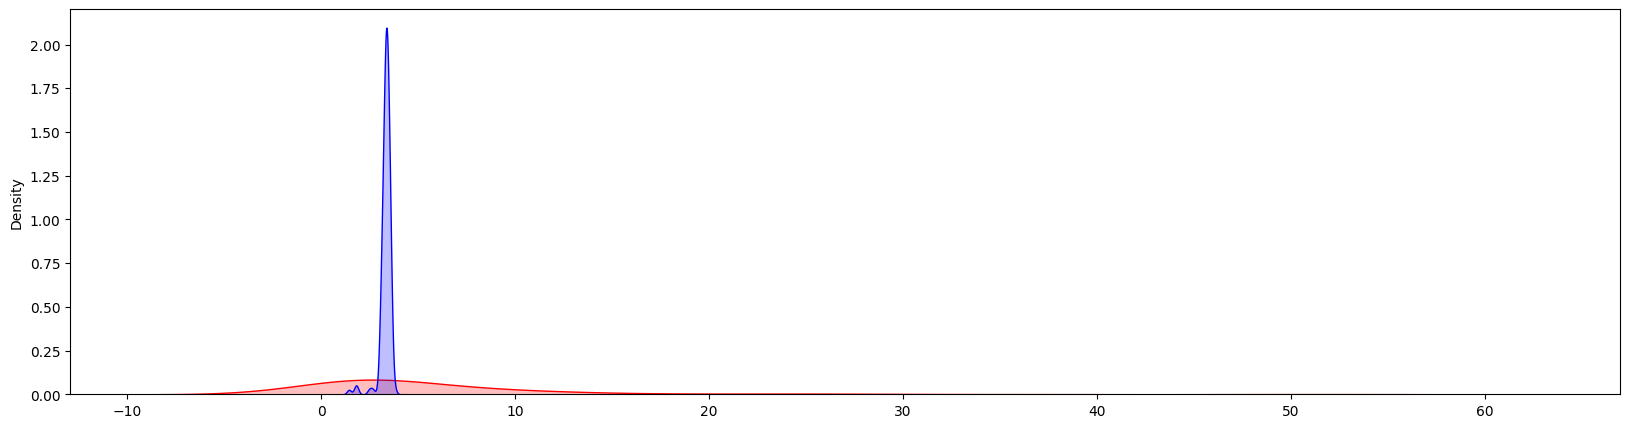

ANN                           


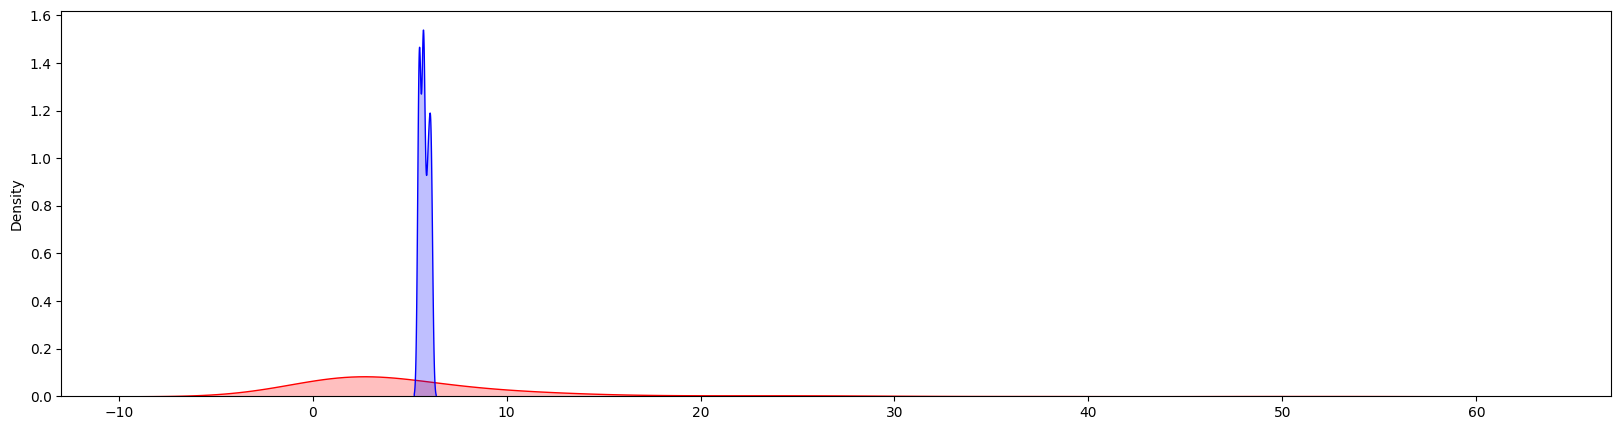

Random Forest Regressor       


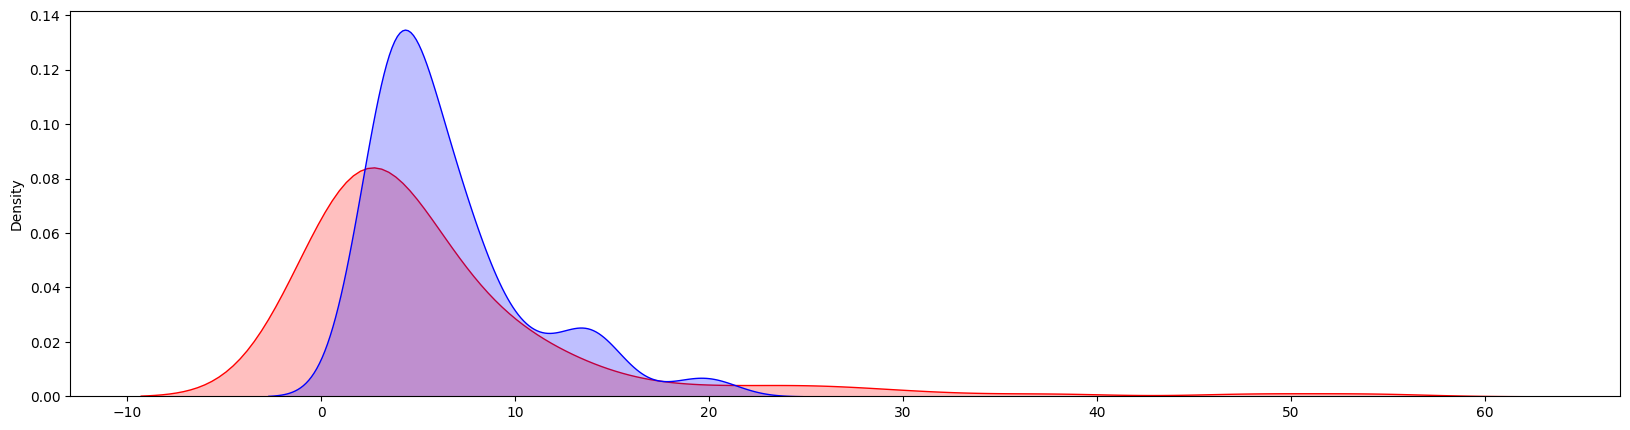

Gradient Boosting Regressor   


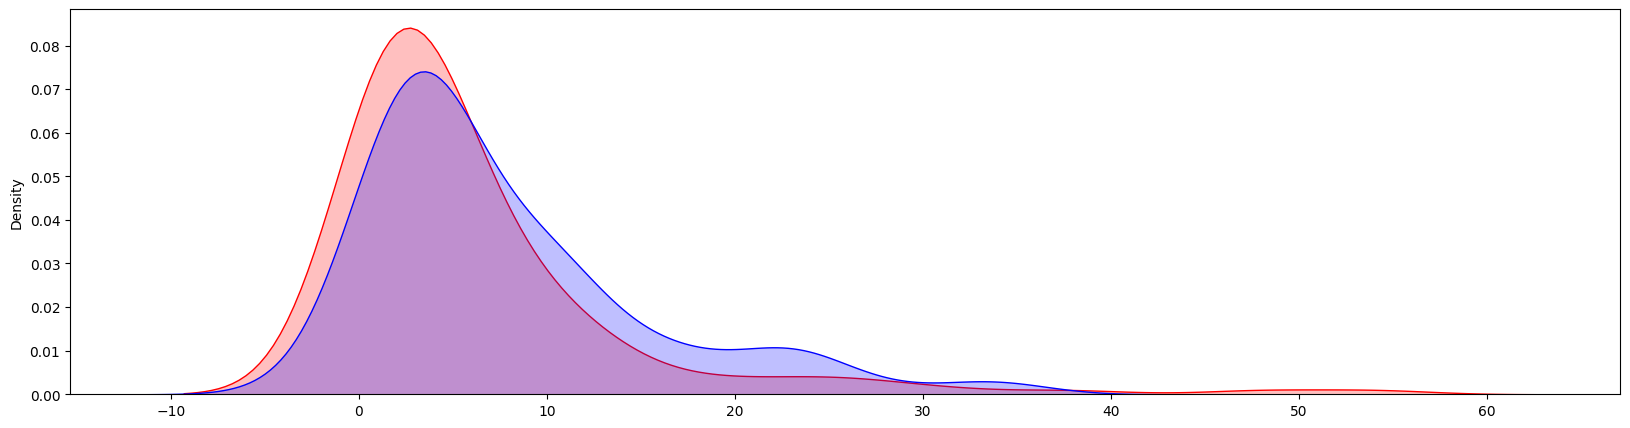

In [13]:
# Get Output variables
hopt = df_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
compute_performance(models, X, y_hopt)

### Adding QY as a feature

In [14]:
df_02_PCE = df.drop(['mat0', 'mat1', 'hopt (%)'])
df_02_PCE = df_02_PCE.drop_nulls()

total, _ = df_02_PCE.shape
for col in df_02_PCE.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_02_PCE.shape

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


shape: (112, 8)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ QY (%) ┆ PCE (%)  │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---    ┆ ---      │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64    ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪════════╪══════════╡
│ 800      ┆ 400     ┆ 800     ┆ 900     ┆ 700    ┆ 1000   ┆ 30.0   ┆ 3.2      │
│ 600      ┆ 400     ┆ 600     ┆ 630     ┆ 600    ┆ 700    ┆ 50.0   ┆ 1.2      │
│ 580      ┆ 300     ┆ 600     ┆ 620     ┆ 600    ┆ 800    ┆ 100.0  ┆ 0.0018   │
│ 745      ┆ 400     ┆ 850     ┆ 808     ┆ 700    ┆ 900    ┆ 25.0   ┆ 0.61     │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...    ┆ ...      │
│ 660      ┆ 480     ┆ 680     ┆ 665     ┆ 600    ┆ 800    ┆ 31.0   ┆ 0.21     │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 60.0   ┆ 0.000198 │
│ 510      ┆ 250     ┆ 520     ┆ 535     ┆ 400    ┆ 650    ┆ 78.0   ┆ 0.000182 │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 60.0   ┆ 0.000471 │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴────────┴──────────┘

In [15]:
df_02_hopt = df.drop(['mat0', 'mat1', 'PCE (%)'])
df_02_hopt = df_02_hopt.drop_nulls()

total, _ = df_02_hopt.shape
for col in df_02_hopt.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_02_hopt.shape

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


shape: (129, 8)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ QY (%) ┆ hopt (%) │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---    ┆ ---      │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64    ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪════════╪══════════╡
│ 578      ┆ 420     ┆ 600     ┆ 613     ┆ 550    ┆ 750    ┆ 98.0   ┆ 18.8     │
│ 800      ┆ 400     ┆ 800     ┆ 900     ┆ 700    ┆ 1000   ┆ 30.0   ┆ 1.4      │
│ 600      ┆ 400     ┆ 600     ┆ 630     ┆ 600    ┆ 700    ┆ 50.0   ┆ 0.5      │
│ 376      ┆ 300     ┆ 650     ┆ 623     ┆ 600    ┆ 700    ┆ 50.0   ┆ 0.3      │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...    ┆ ...      │
│ 660      ┆ 480     ┆ 680     ┆ 665     ┆ 600    ┆ 800    ┆ 31.0   ┆ 2.65     │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 60.0   ┆ 0.02     │
│ 510      ┆ 250     ┆ 520     ┆ 535     ┆ 400    ┆ 650    ┆ 78.0   ┆ 0.035    │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 60.0   ┆ 0.048    │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴────────┴──────────┘

PCE
Linear Regression             : 1.7140184379628969
K Neighbors Regressor         : 1.3722440314033562
Lasso Regression              : 1.6197613401923683
Support Vector Regressor      : 1.450151868767131
ANN                           : 1.5843095282962598
Random Forest Regressor       : 1.3670279482735295
Gradient Boosting Regressor   : 1.474034508264072

Linear Regression             


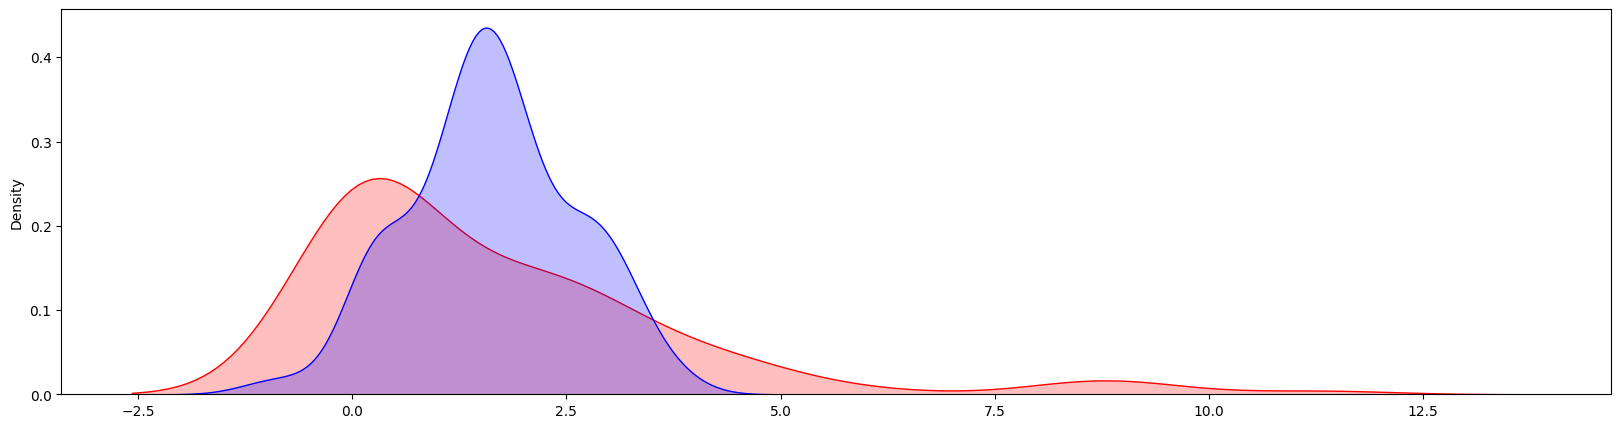

K Neighbors Regressor         


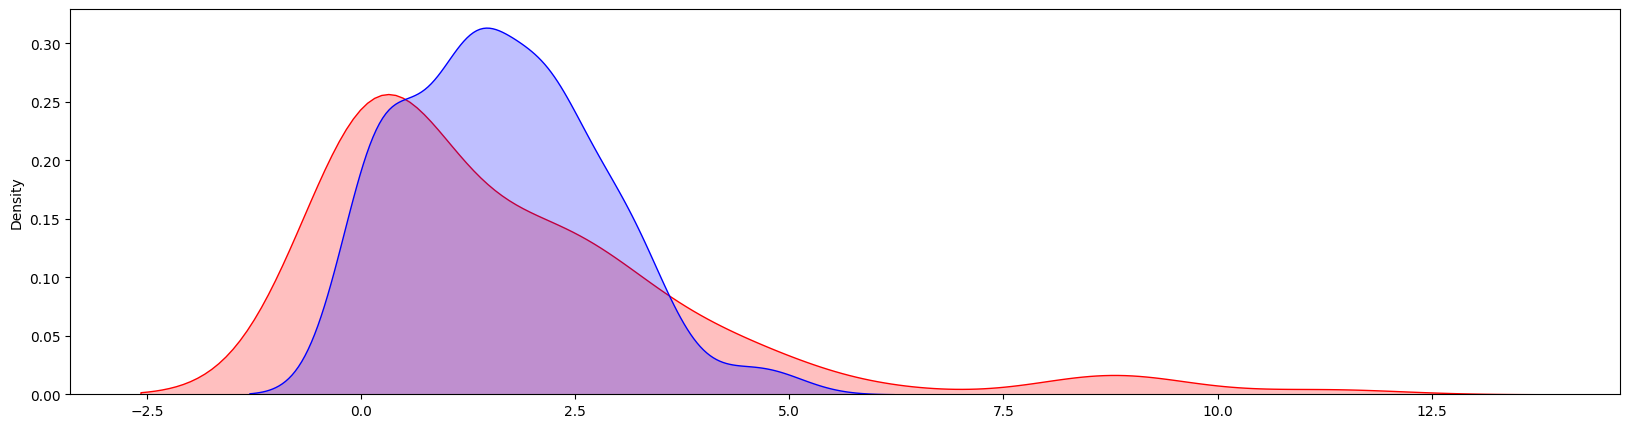

Lasso Regression              


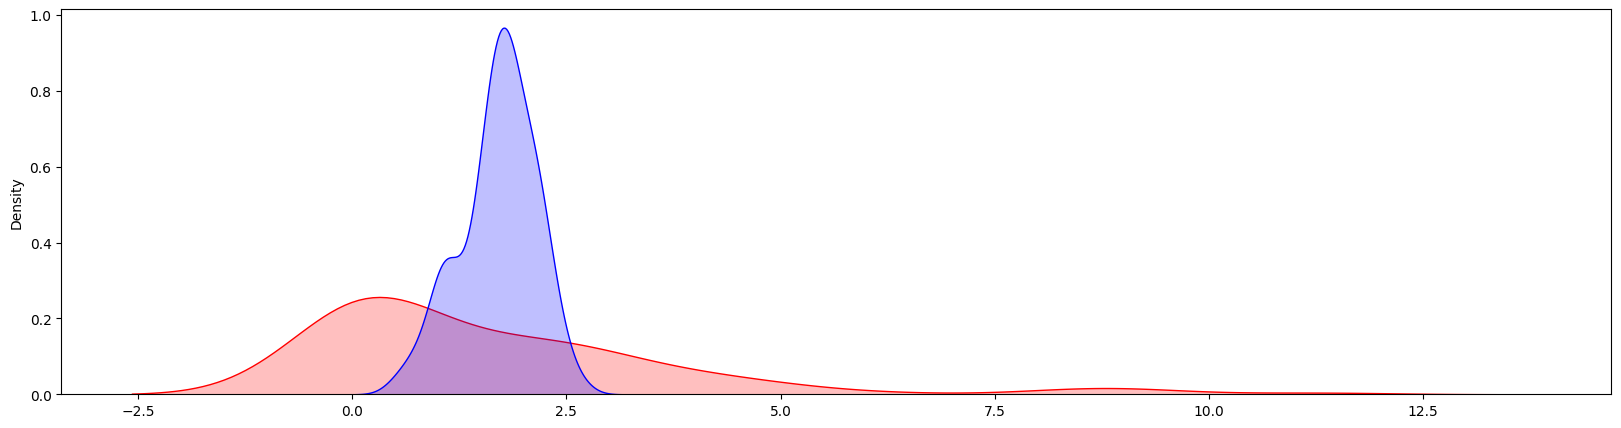

Support Vector Regressor      


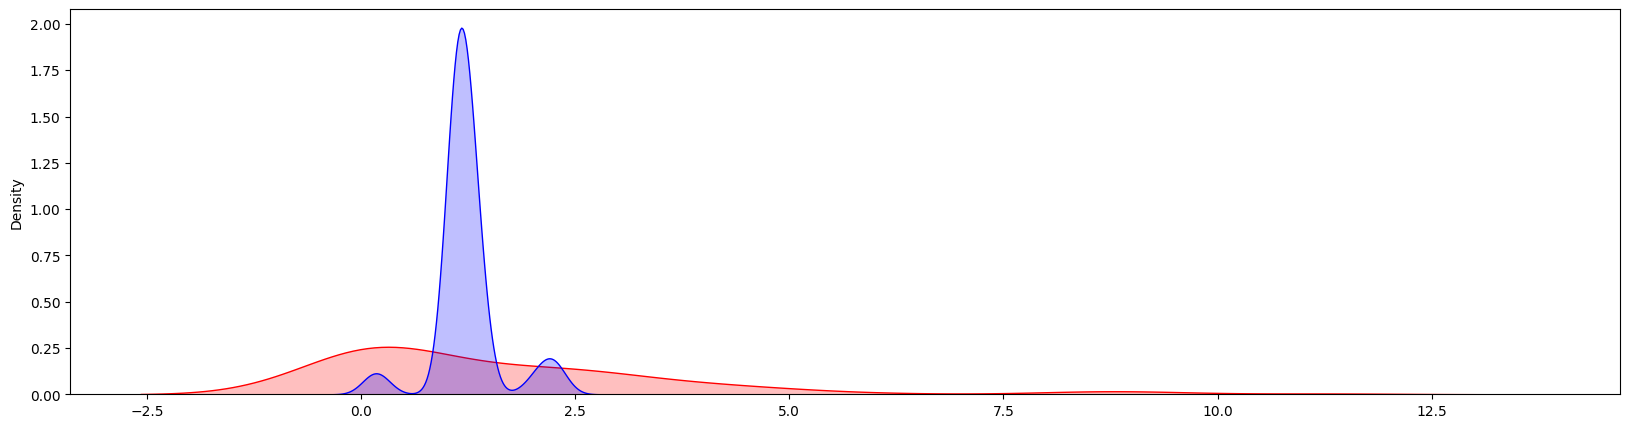

ANN                           


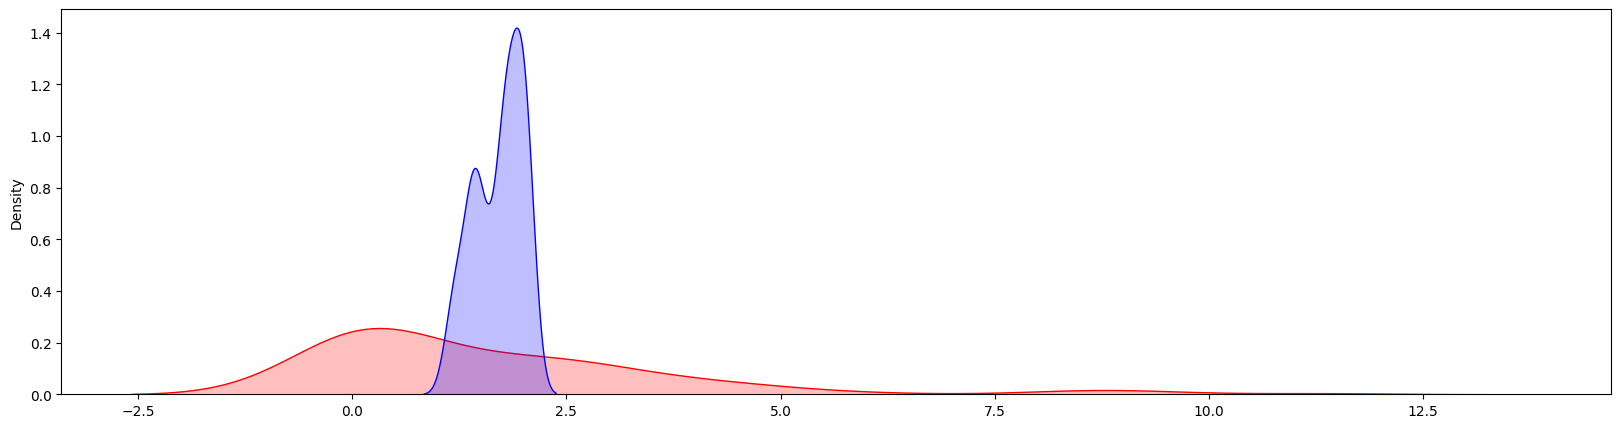

Random Forest Regressor       


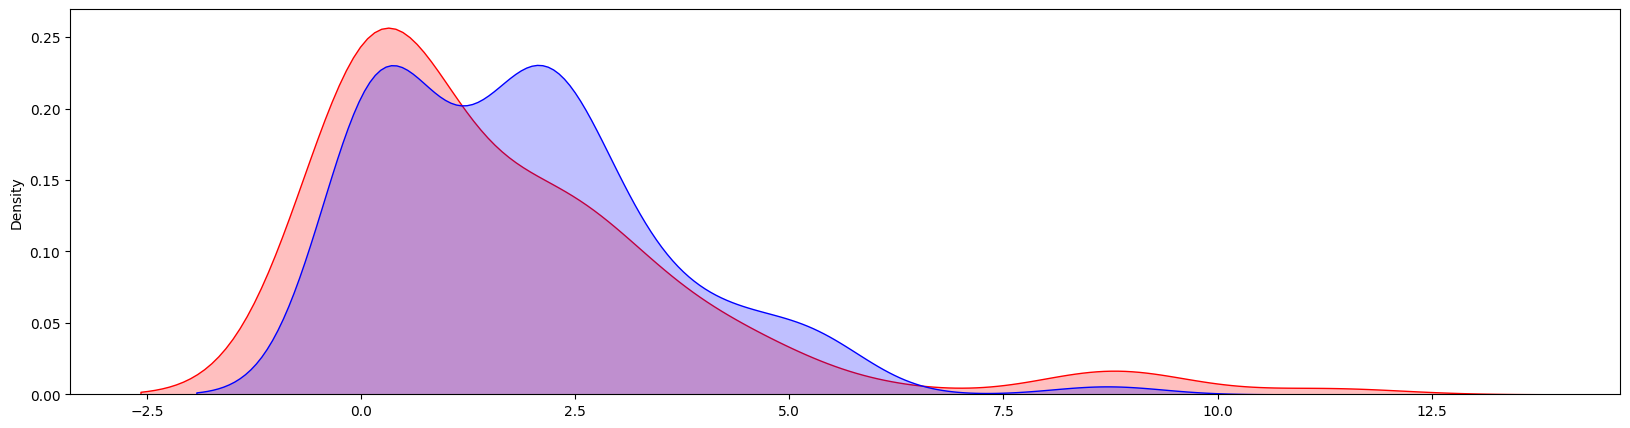

Gradient Boosting Regressor   


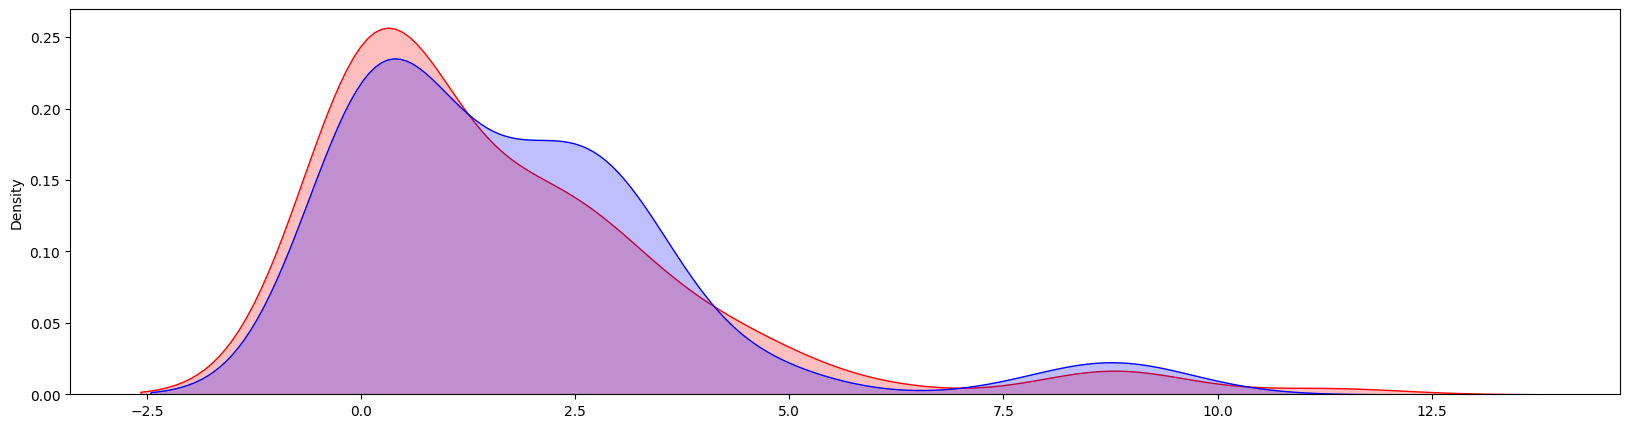

In [16]:
# Get Output variables
PCE = df_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
compute_performance(models, X, y_PCE)

hopt
Linear Regression             : 6.503879324721308
K Neighbors Regressor         : 5.011309537275463
Lasso Regression              : 5.7304593869731795
Support Vector Regressor      : 4.747957118031424
ANN                           : 5.46595323324444
Random Forest Regressor       : 5.196159874073513
Gradient Boosting Regressor   : 4.952010459463777

Linear Regression             


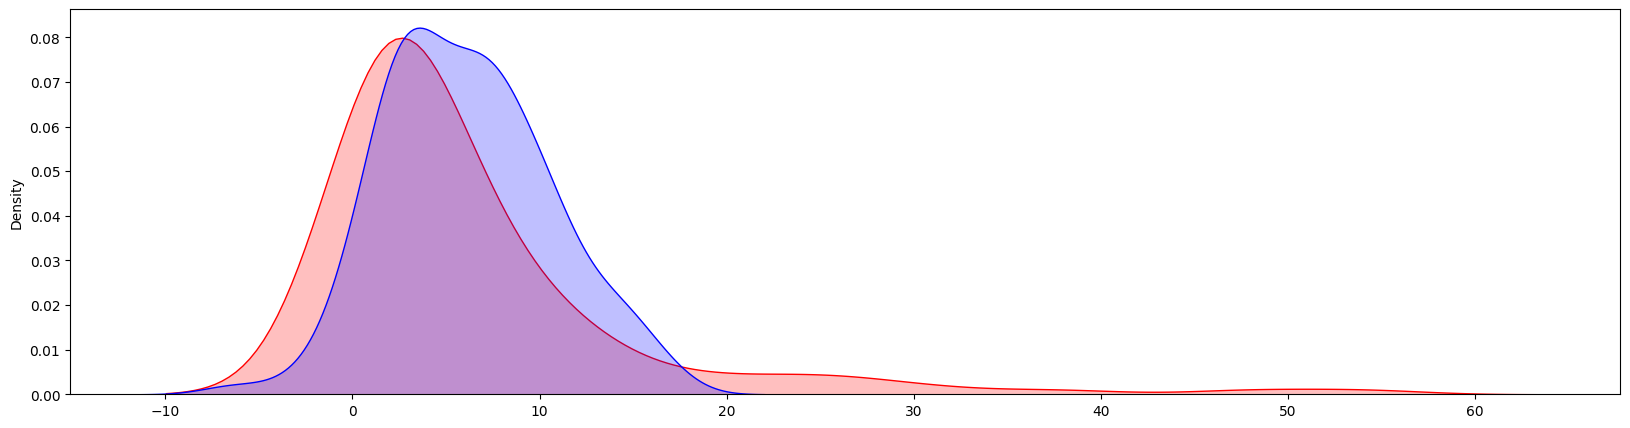

K Neighbors Regressor         


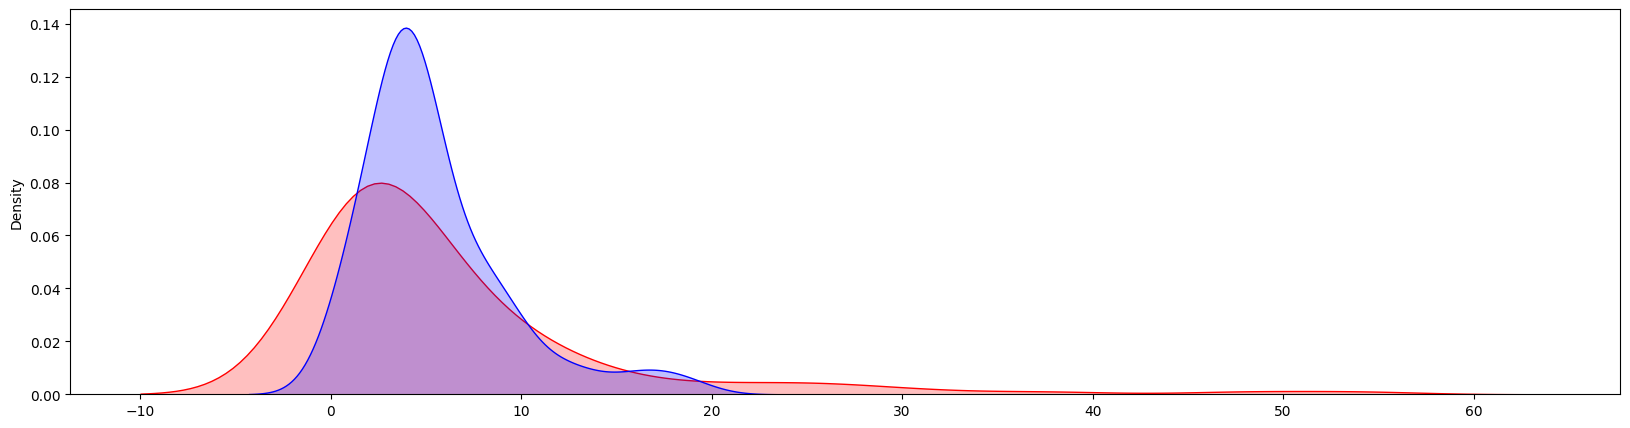

Lasso Regression              


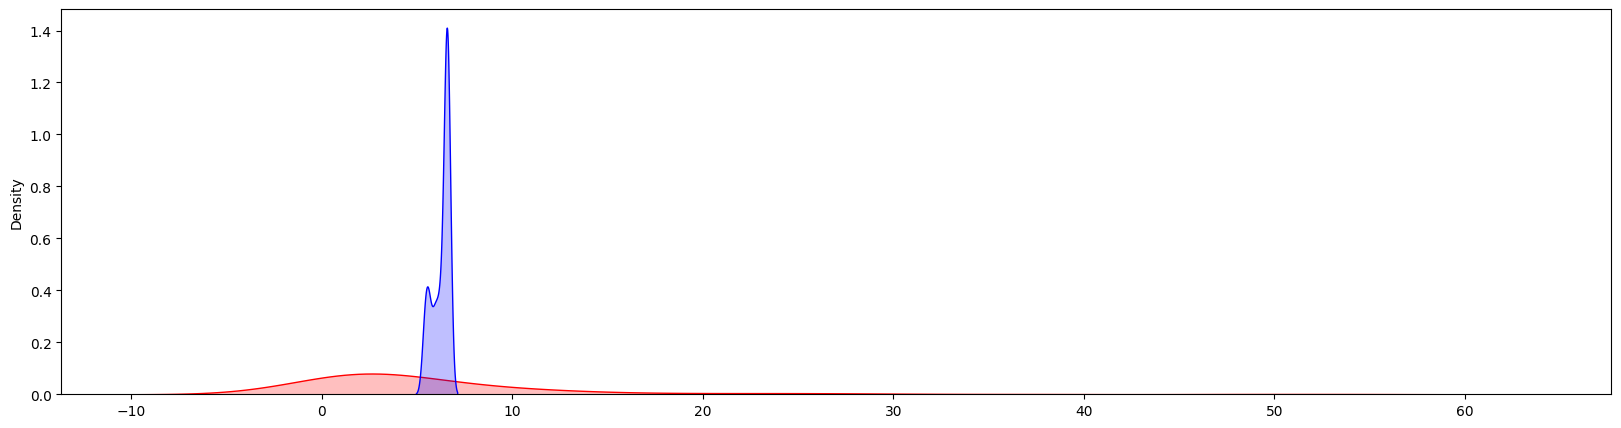

Support Vector Regressor      


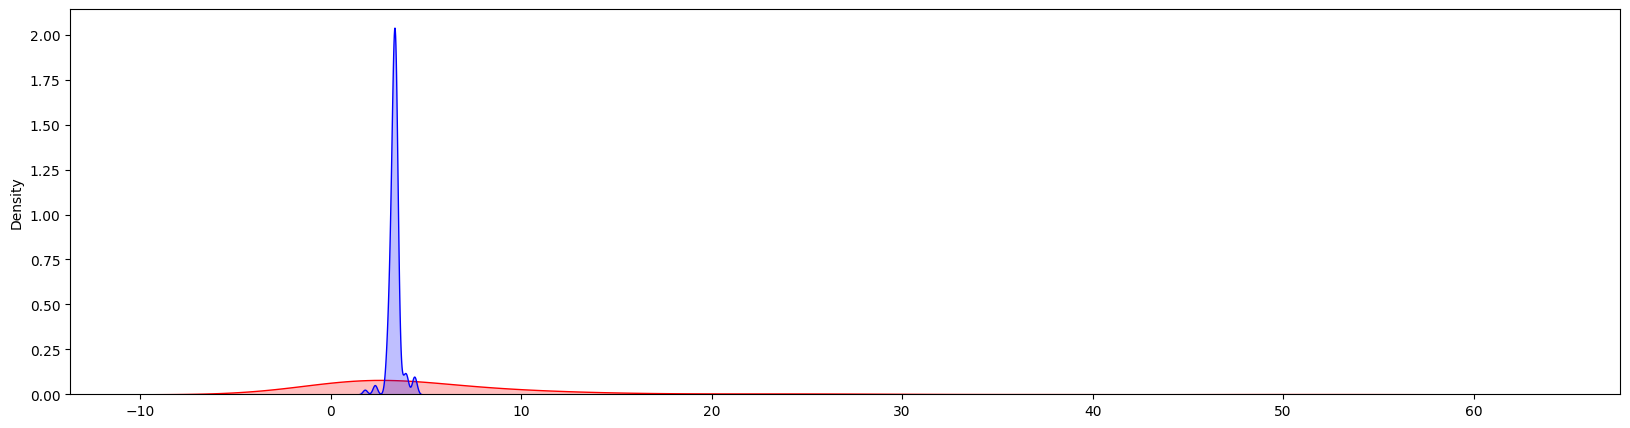

ANN                           


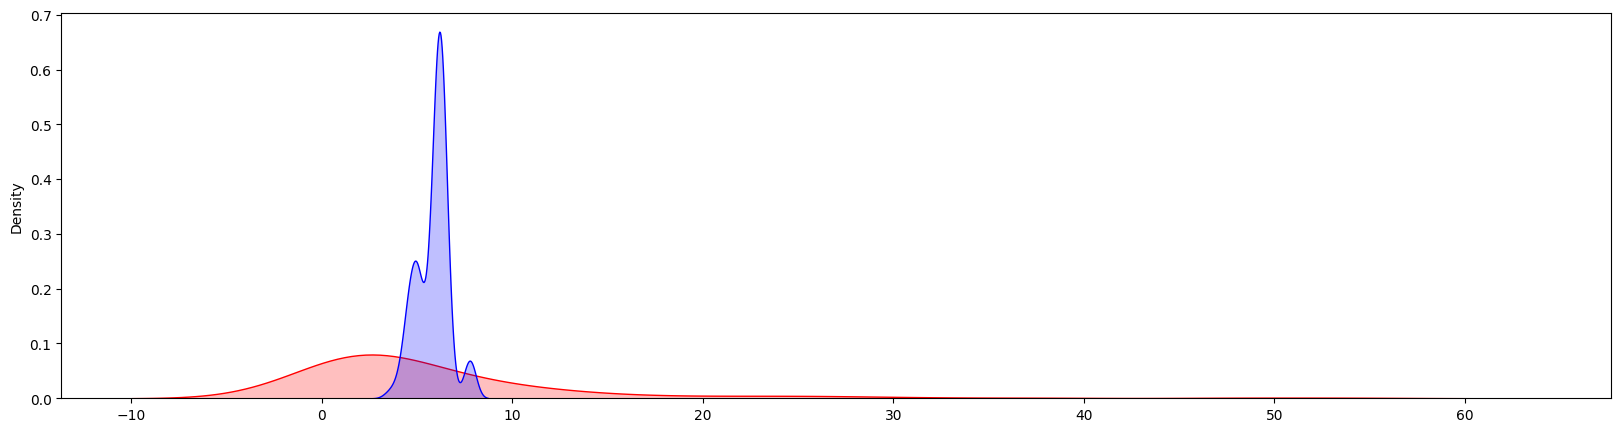

Random Forest Regressor       


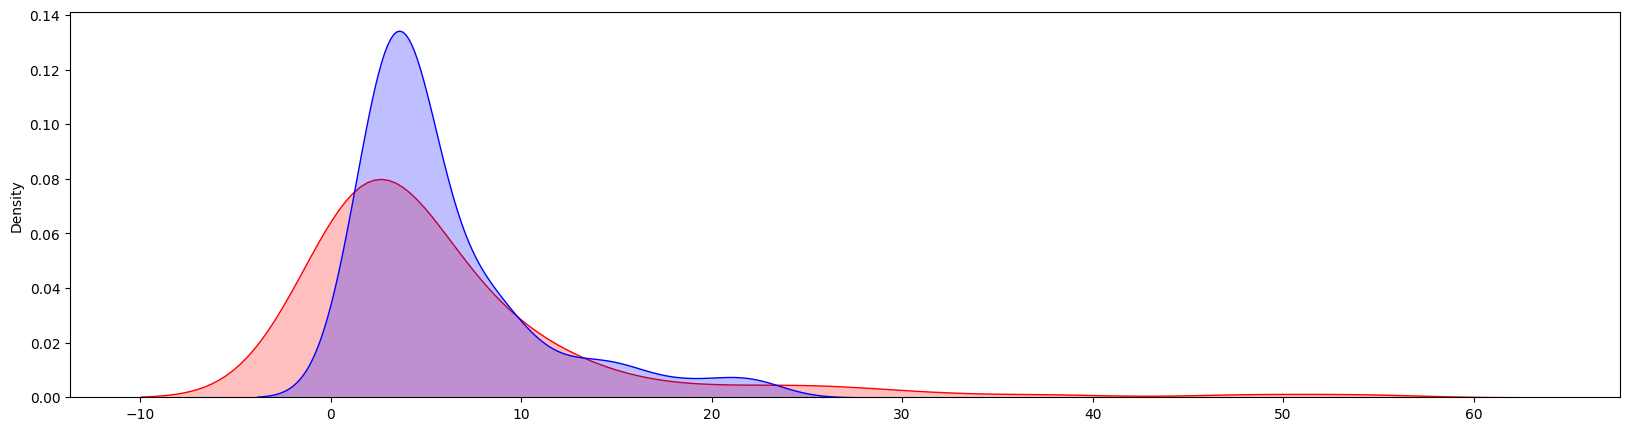

Gradient Boosting Regressor   


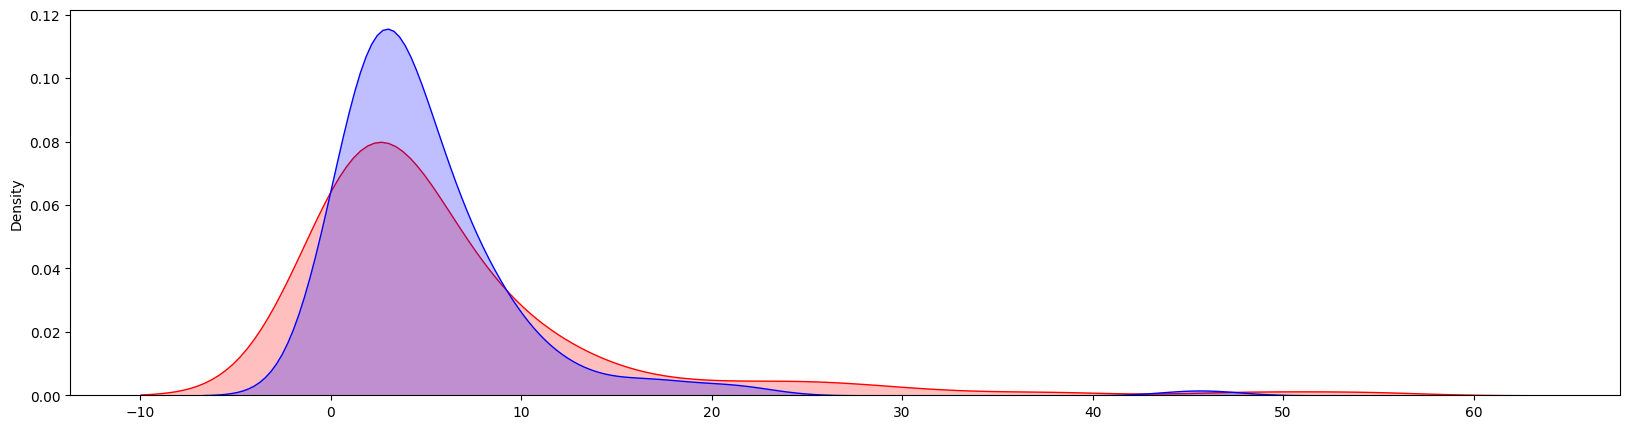

In [17]:
# Get Output variables
hopt = df_02_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()


## hopt
print(f'hopt')
compute_performance(models, X, y_hopt)

### Adding the categorical features (Mat0 and Mat1)

In [18]:
df_03_PCE = df.drop(['hopt (%)'])
df_03_PCE = df_03_PCE.drop_nulls()

total, _ = df_03_PCE.shape
for col in df_03_PCE.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_03_PCE.shape

mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


shape: (112, 10)
┌──────┬──────────┬──────────┬─────────┬─────┬────────┬────────┬────────┬──────────┐
│ mat0 ┆ mat1     ┆ abs_peak ┆ abs_min ┆ ... ┆ em_min ┆ em_max ┆ QY (%) ┆ PCE (%)  │
│ ---  ┆ ---      ┆ ---      ┆ ---     ┆     ┆ ---    ┆ ---    ┆ ---    ┆ ---      │
│ str  ┆ str      ┆ i64      ┆ i64     ┆     ┆ i64    ┆ i64    ┆ f64    ┆ f64      │
╞══════╪══════════╪══════════╪═════════╪═════╪════════╪════════╪════════╪══════════╡
│ QD   ┆ solution ┆ 800      ┆ 400     ┆ ... ┆ 700    ┆ 1000   ┆ 30.0   ┆ 3.2      │
│ QD   ┆ solution ┆ 600      ┆ 400     ┆ ... ┆ 600    ┆ 700    ┆ 50.0   ┆ 1.2      │
│ dye  ┆ bulk     ┆ 580      ┆ 300     ┆ ... ┆ 600    ┆ 800    ┆ 100.0  ┆ 0.0018   │
│ dye  ┆ film     ┆ 745      ┆ 400     ┆ ... ┆ 700    ┆ 900    ┆ 25.0   ┆ 0.61     │
│ ...  ┆ ...      ┆ ...      ┆ ...     ┆ ... ┆ ...    ┆ ...    ┆ ...    ┆ ...      │
│ dye  ┆ solution ┆ 660      ┆ 480     ┆ ... ┆ 600    ┆ 800    ┆ 31.0   ┆ 0.21     │
│ Ln   ┆ film     ┆ 370      ┆ 250     ┆ ... ┆ 570    ┆ 720    ┆ 60.0   ┆ 0.000198 │
│ CD   ┆ film     ┆ 510      ┆ 250     ┆ ... ┆ 400    ┆ 650    ┆ 78.0   ┆ 0.000182 │
│ Ln   ┆ film     ┆ 370      ┆ 250     ┆ ... ┆ 570    ┆ 720    ┆ 60.0   ┆ 0.000471 │
└──────┴──────────┴──────────┴─────────┴─────┴────────┴────────┴────────┴──────────┘

In [19]:
df_03_hopt = df.drop(['PCE (%)'])
df_03_hopt = df_03_hopt.drop_nulls()

total, _ = df_03_hopt.shape
for col in df_03_hopt.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_03_hopt.shape

mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


shape: (129, 10)
┌──────┬──────────┬──────────┬─────────┬─────┬────────┬────────┬────────┬──────────┐
│ mat0 ┆ mat1     ┆ abs_peak ┆ abs_min ┆ ... ┆ em_min ┆ em_max ┆ QY (%) ┆ hopt (%) │
│ ---  ┆ ---      ┆ ---      ┆ ---     ┆     ┆ ---    ┆ ---    ┆ ---    ┆ ---      │
│ str  ┆ str      ┆ i64      ┆ i64     ┆     ┆ i64    ┆ i64    ┆ f64    ┆ f64      │
╞══════╪══════════╪══════════╪═════════╪═════╪════════╪════════╪════════╪══════════╡
│ dye  ┆ film     ┆ 578      ┆ 420     ┆ ... ┆ 550    ┆ 750    ┆ 98.0   ┆ 18.8     │
│ QD   ┆ solution ┆ 800      ┆ 400     ┆ ... ┆ 700    ┆ 1000   ┆ 30.0   ┆ 1.4      │
│ QD   ┆ solution ┆ 600      ┆ 400     ┆ ... ┆ 600    ┆ 700    ┆ 50.0   ┆ 0.5      │
│ QD   ┆ solution ┆ 376      ┆ 300     ┆ ... ┆ 600    ┆ 700    ┆ 50.0   ┆ 0.3      │
│ ...  ┆ ...      ┆ ...      ┆ ...     ┆ ... ┆ ...    ┆ ...    ┆ ...    ┆ ...      │
│ dye  ┆ solution ┆ 660      ┆ 480     ┆ ... ┆ 600    ┆ 800    ┆ 31.0   ┆ 2.65     │
│ Ln   ┆ film     ┆ 370      ┆ 250     ┆ ... ┆ 570    ┆ 720    ┆ 60.0   ┆ 0.02     │
│ CD   ┆ film     ┆ 510      ┆ 250     ┆ ... ┆ 400    ┆ 650    ┆ 78.0   ┆ 0.035    │
│ Ln   ┆ film     ┆ 370      ┆ 250     ┆ ... ┆ 570    ┆ 720    ┆ 60.0   ┆ 0.048    │
└──────┴──────────┴──────────┴─────────┴─────┴────────┴────────┴────────┴──────────┘

PCE
Linear Regression             : 1.4422790892631234
K Neighbors Regressor         : 1.3735483234093182
Lasso Regression              : 1.4300750820588997
Support Vector Regressor      : 1.4501209762714977


/home/mantunes/git/sunlight-harvesting-energy-conversion/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e+00, tolerance: 5.286e-01
  model = cd_fast.enet_coordinate_descent(
/home/mantunes/git/sunlight-harvesting-energy-conversion/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e+00, tolerance: 4.675e-01
  model = cd_fast.enet_coordinate_descent(
/home/mantunes/git/sunlight-harvesting-energy-conversion/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might wa

ANN                           : 1.5829456538035385
Random Forest Regressor       : 1.4657168263604556
Gradient Boosting Regressor   : 1.559147817315118

Linear Regression             


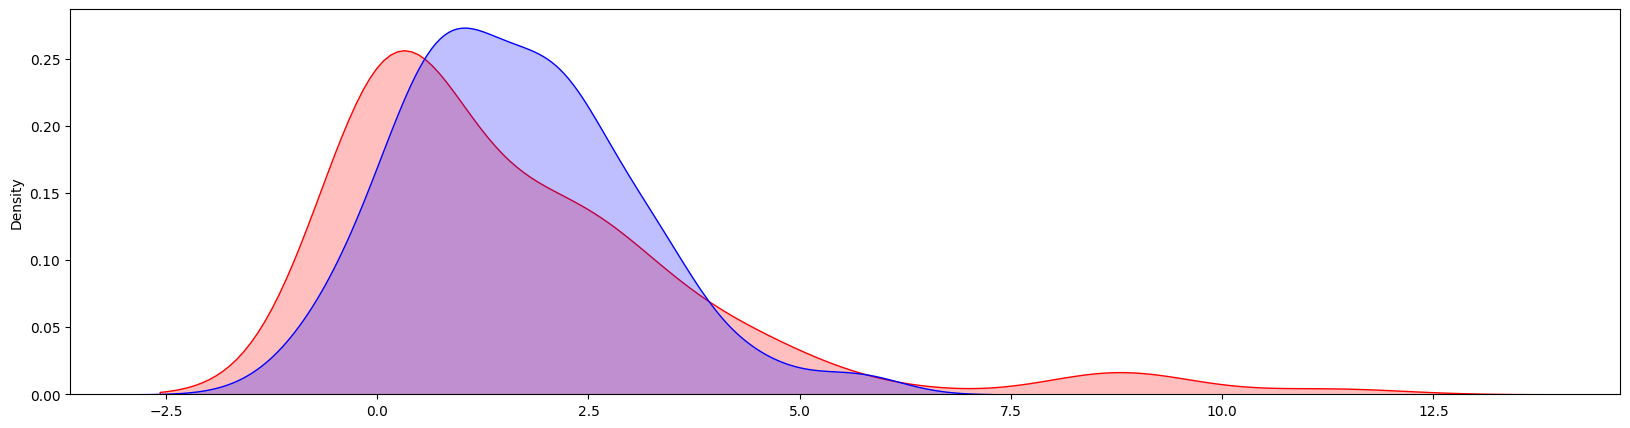

K Neighbors Regressor         


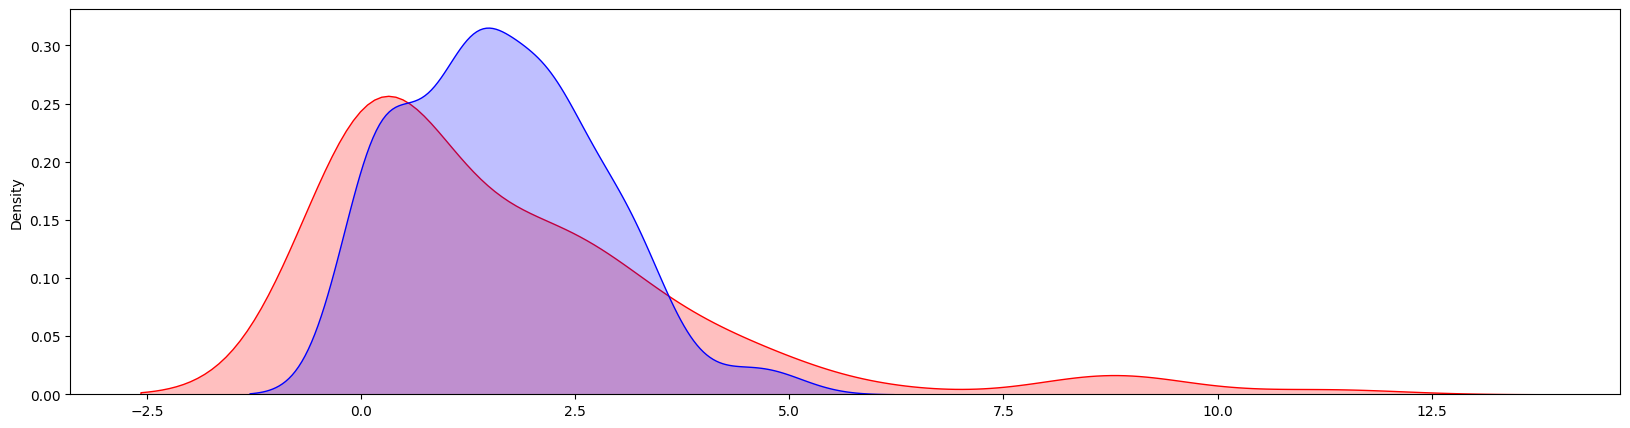

Lasso Regression              


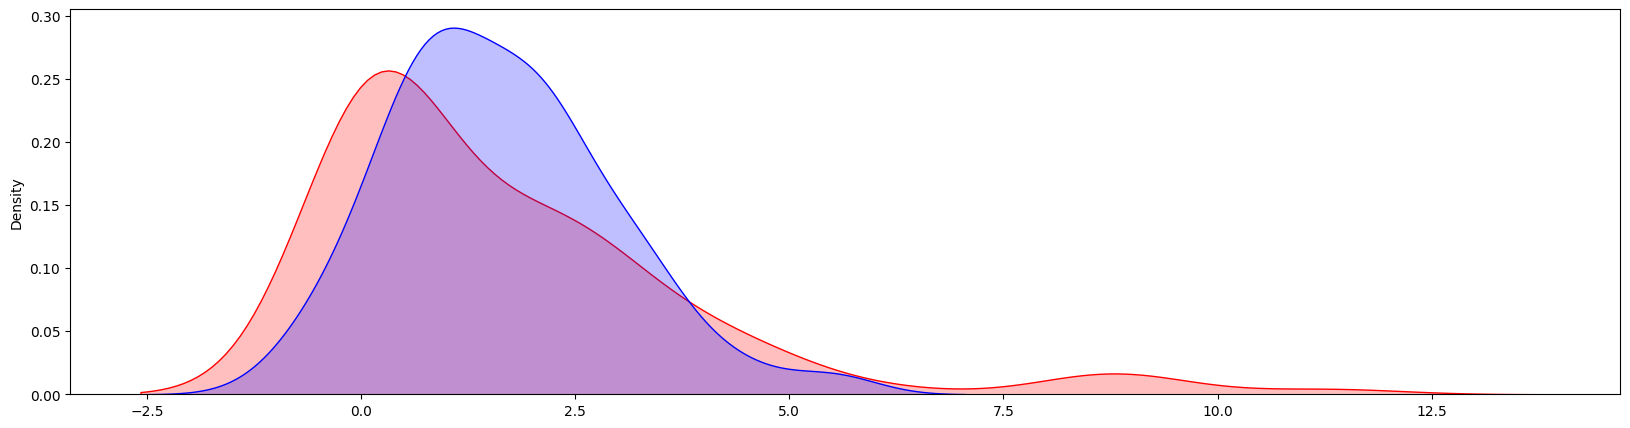

Support Vector Regressor      


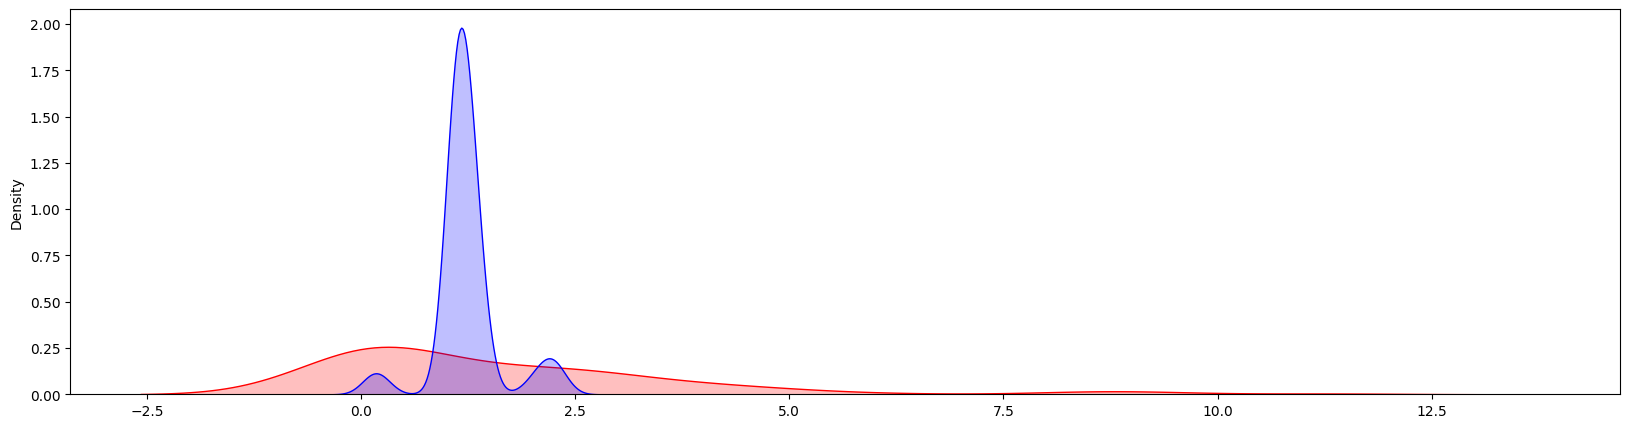

ANN                           


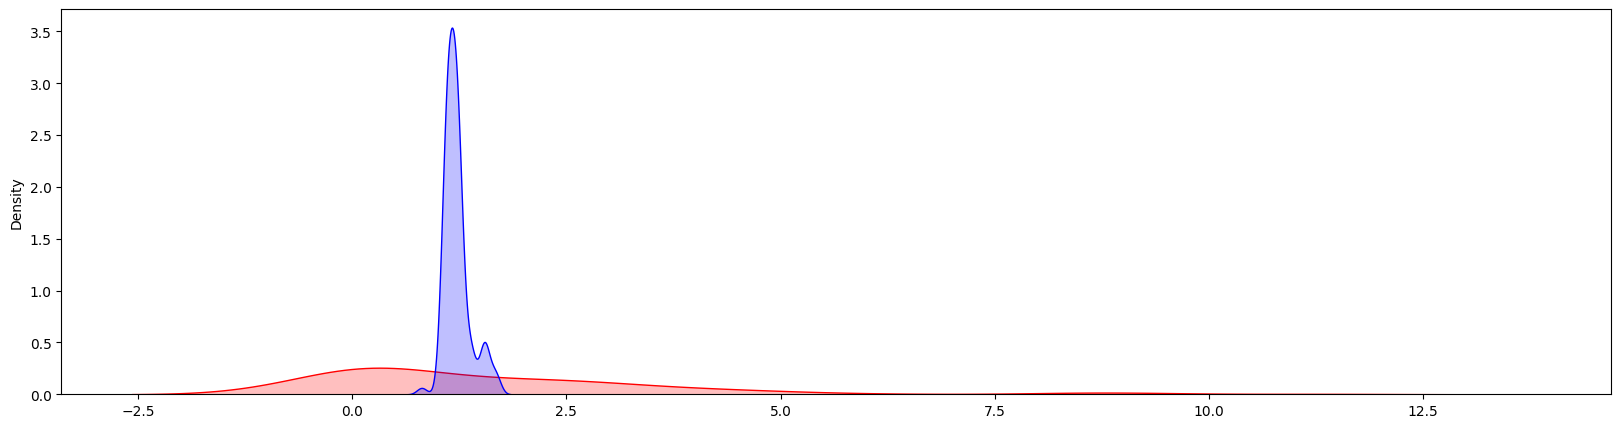

Random Forest Regressor       


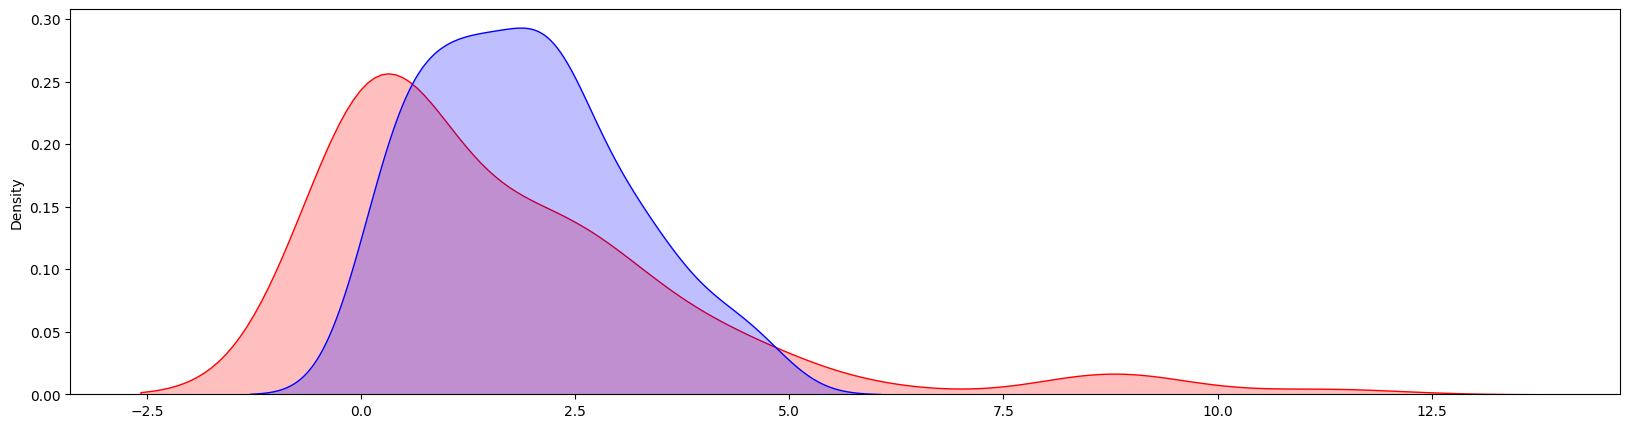

Gradient Boosting Regressor   


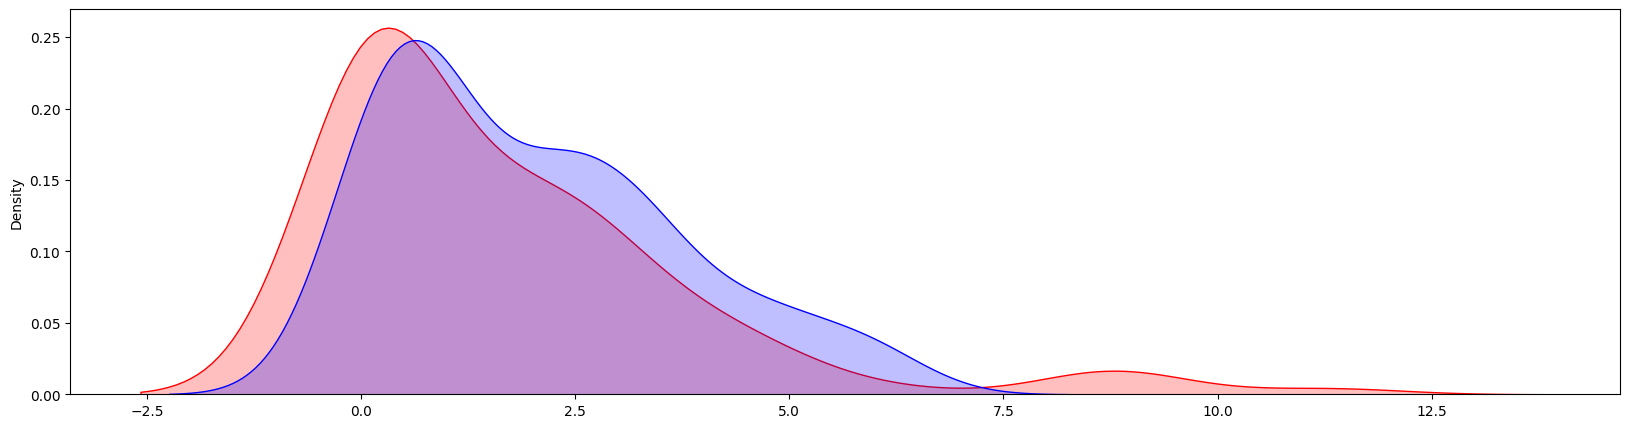

In [20]:
# Get Output variables
PCE = df_03_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_PCE.drop(['mat0', 'mat1', 'PCE (%)'])
X = df_input.to_numpy()

temp_mat0 = df_03_PCE[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_03_PCE[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'PCE')
compute_performance(models, X, y_PCE)

hopt
Linear Regression             : 6.183300640942351
K Neighbors Regressor         : 5.038463606150215
Lasso Regression              : 5.7304593869731795
Support Vector Regressor      : 4.747939711337265


/home/mantunes/git/sunlight-harvesting-energy-conversion/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.978e+01, tolerance: 9.612e+00
  model = cd_fast.enet_coordinate_descent(
/home/mantunes/git/sunlight-harvesting-energy-conversion/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+01, tolerance: 9.461e+00
  model = cd_fast.enet_coordinate_descent(
/home/mantunes/git/sunlight-harvesting-energy-conversion/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might wa

ANN                           : 5.2230785839970135
Random Forest Regressor       : 4.486069077892443
Gradient Boosting Regressor   : 4.262899012567507

Linear Regression             


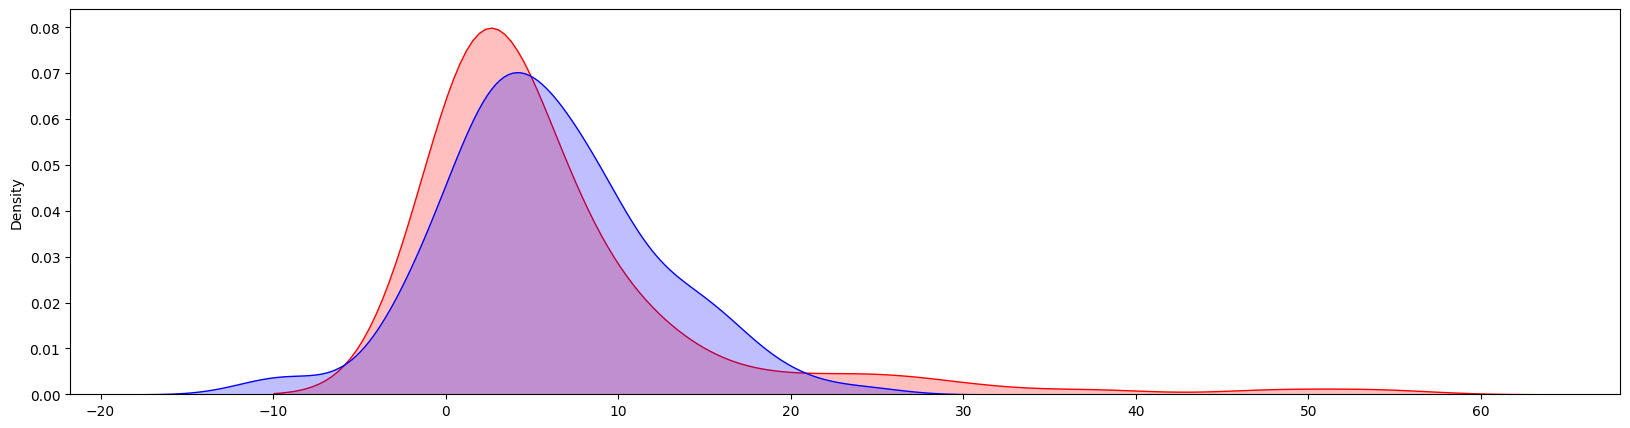

K Neighbors Regressor         


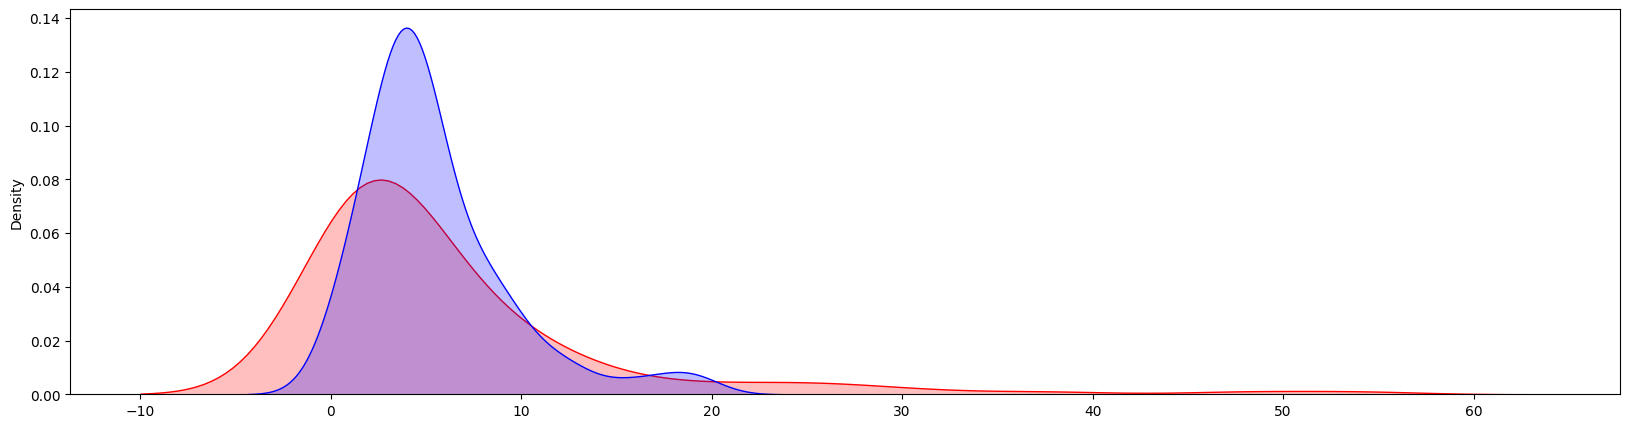

Lasso Regression              


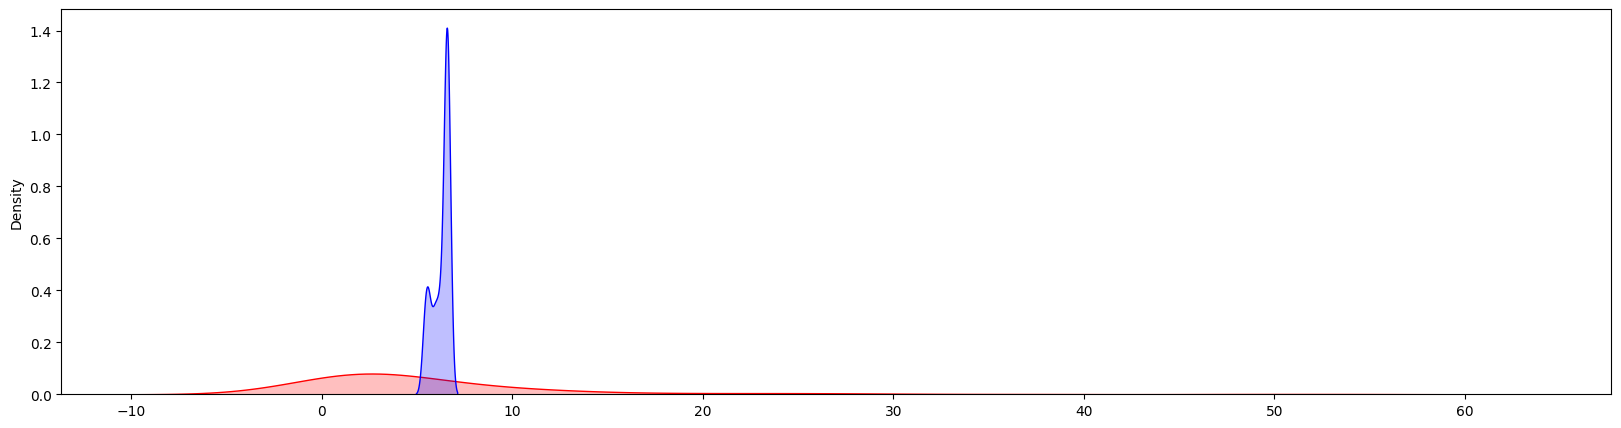

Support Vector Regressor      


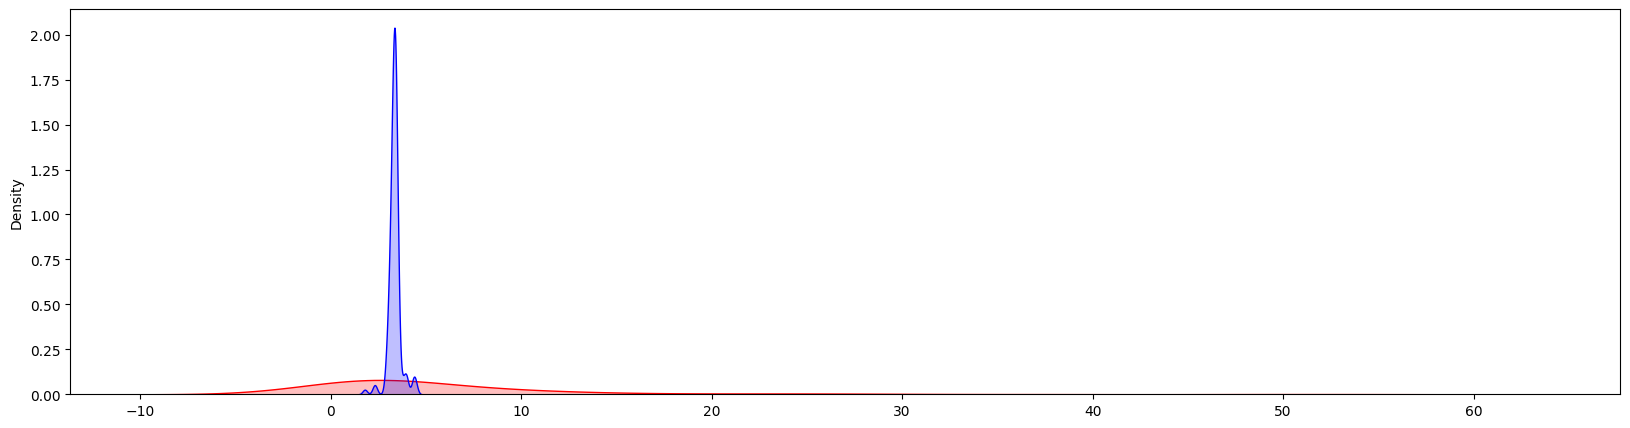

ANN                           


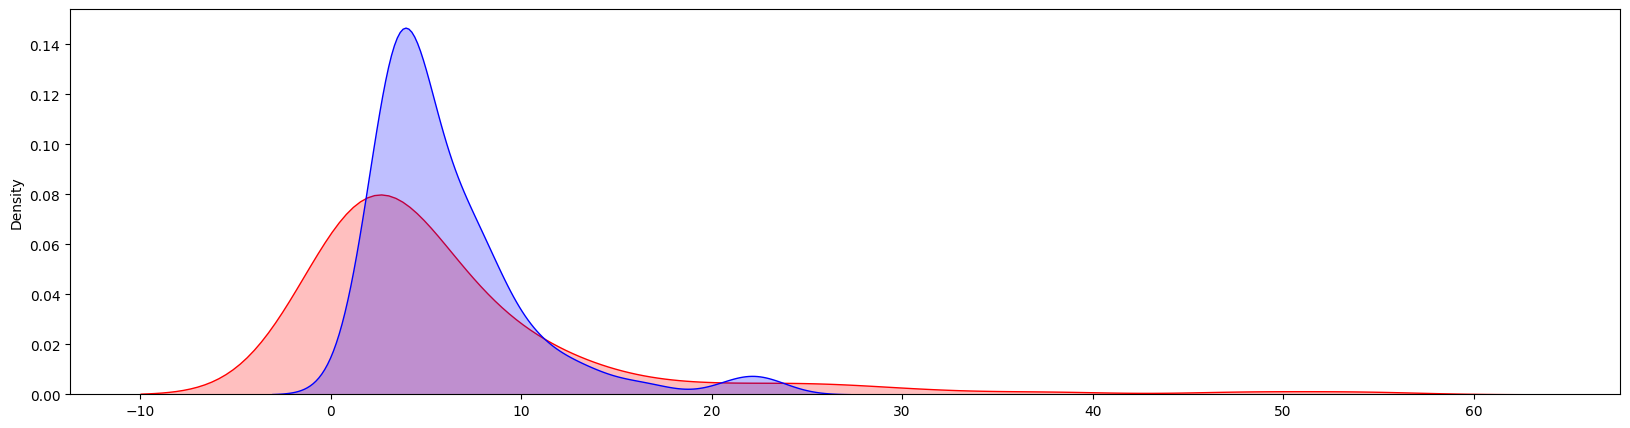

Random Forest Regressor       


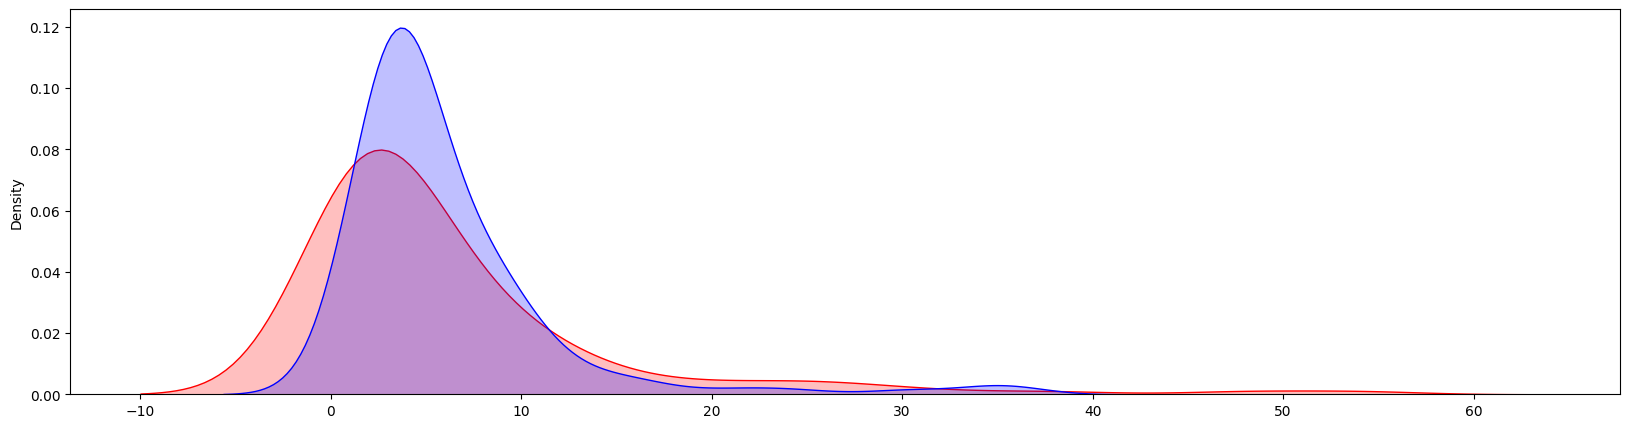

Gradient Boosting Regressor   


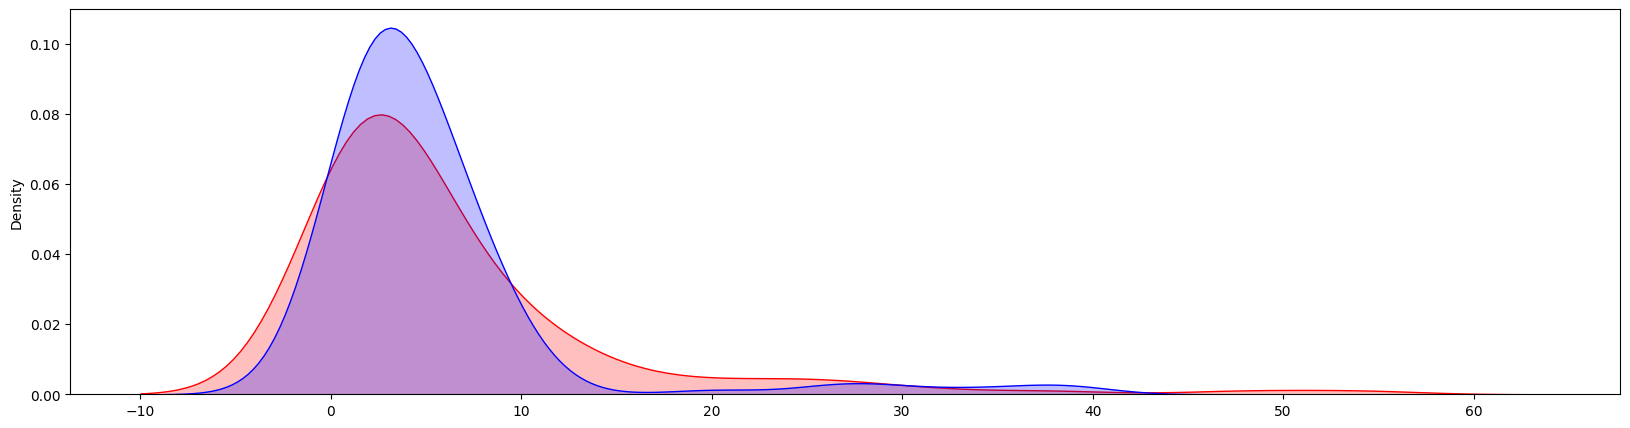

In [21]:
# Get Output variables
hopt = df_03_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_hopt.drop(['mat0', 'mat1', 'hopt (%)'])
X = df_input.to_numpy()

temp_mat0 = df_03_hopt[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_03_hopt[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## hopt
print(f'hopt')
compute_performance(models, X, y_hopt)

## Outlier removal

In [4]:
def iqr(array):
    Q1 = np.percentile(array, 25)
    Q3 = np.percentile(array, 75)
    IQR = Q3 - Q1
    return ((Q1 - 1.5 * IQR),(Q3 + 1.5 * IQR))

In [5]:
PCE = df[['PCE (%)']]
PCE_array = PCE.drop_nulls().to_numpy()[:,0]
PCE_array

pce_low, pce_high = iqr(PCE_array)
print(f'PCE [{pce_low}, {pce_high}]')

PCE [-4.035, 6.981]


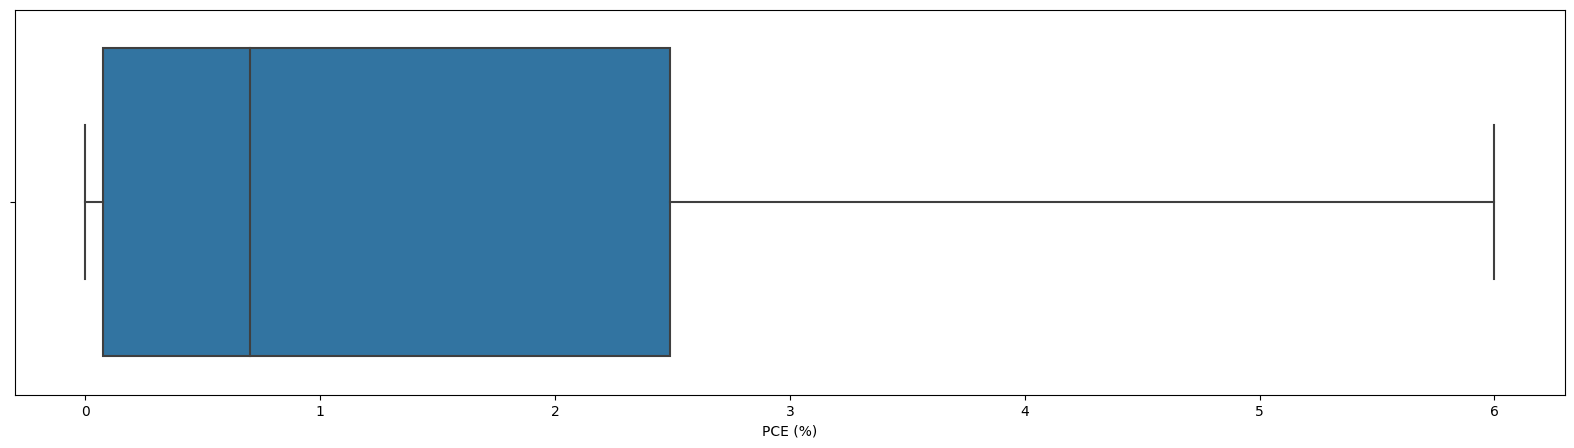

In [6]:
df_filtered_PCE = df.filter((pl.col('PCE (%)') > pce_low) & (pl.col('PCE (%)') < pce_high))

sns.boxplot(data=df_filtered_PCE.to_pandas(), x='PCE (%)')
plt.show()

In [7]:
hopt = df[['hopt (%)']]
hopt_array = hopt.drop_nulls().to_numpy()[:,0]
hopt_array

hopt_low, hopt_high = iqr(hopt_array)
print(f'PCE [{hopt_low}, {hopt_high}]')

PCE [-6.99875, 15.63125]


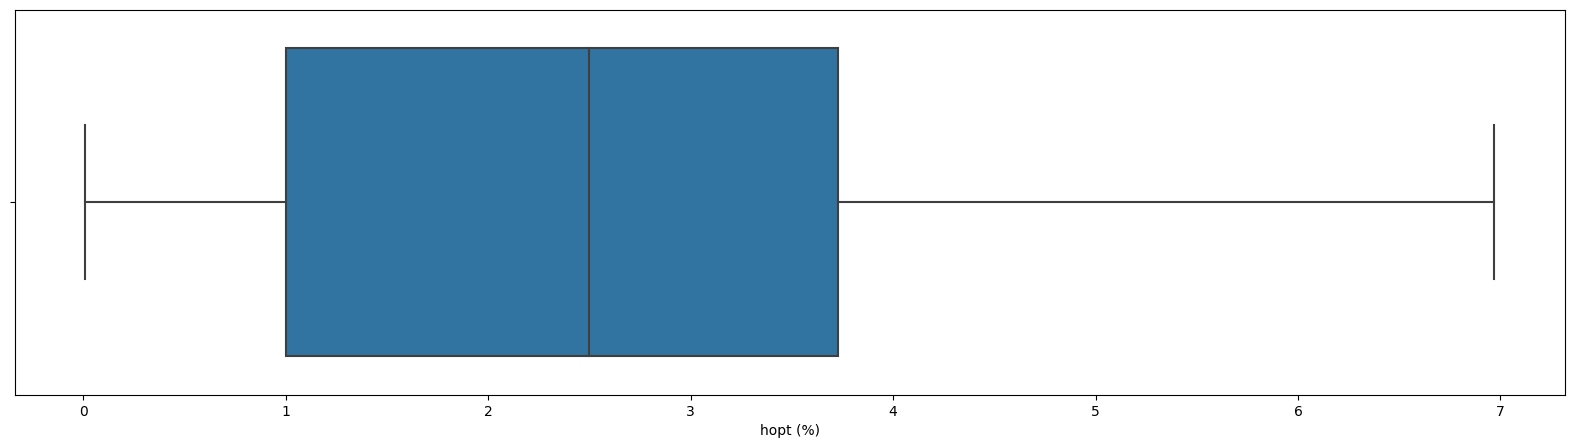

In [8]:
df_filtered_hopt = df.filter((pl.col('hopt (%)') > pce_low) & (pl.col('hopt (%)') < pce_high))

sns.boxplot(data=df_filtered_hopt.to_pandas(), x='hopt (%)')
plt.show()

### PCE and hopt baselines

In [11]:
models_gbr = [('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42),
           {'n_estimators':[50, 100, 150],'min_samples_split':[2, 5, 10],
            'min_samples_leaf':[1, 2, 4],'max_depth':max_depth})]

In [12]:
df_baseline_PCE = df_filtered_PCE.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)'])
df_baseline_PCE = df_baseline_PCE.drop_nulls()

total, _ = df_baseline_PCE.shape
for col in df_baseline_PCE.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_baseline_PCE.shape

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


(121, 7)

PCE
Gradient Boosting Regressor   : 0.8796479542840906

Gradient Boosting Regressor   


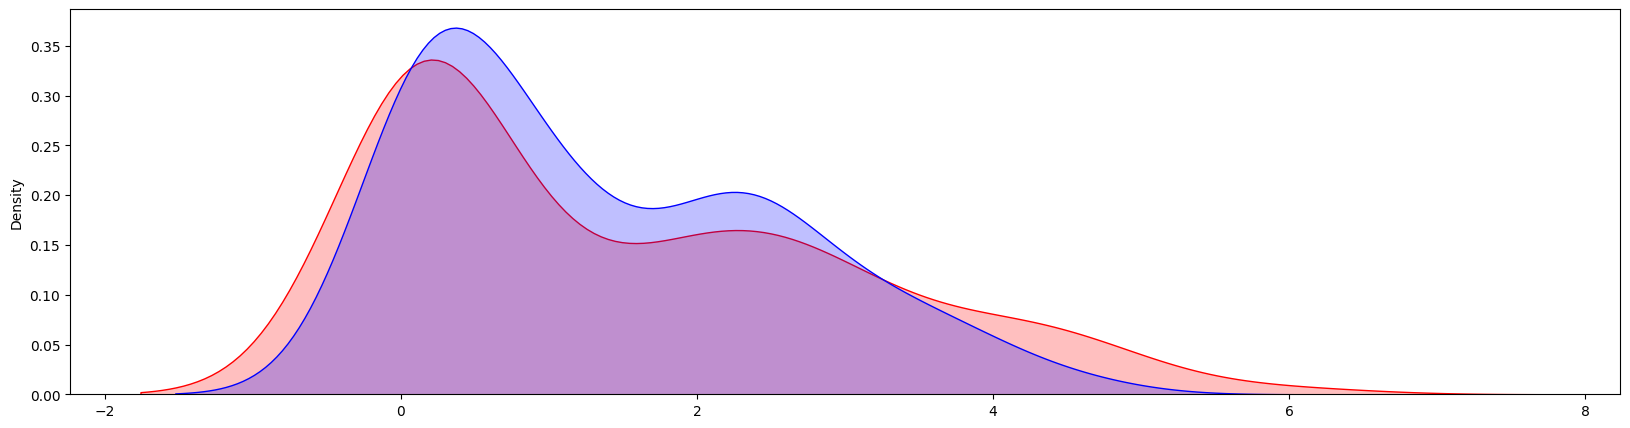

In [15]:
# Get Output variables
PCE = df_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
compute_performance(models_gbr, X, y_PCE)

In [16]:
df_baseline_hopt = df_filtered_hopt.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)'])
df_baseline_hopt = df_baseline_hopt.drop_nulls()

total, _ = df_baseline_hopt.shape
for col in df_baseline_hopt.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_baseline_hopt.shape

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


(107, 7)

hopt
Gradient Boosting Regressor   : 1.7159296456564799

Gradient Boosting Regressor   


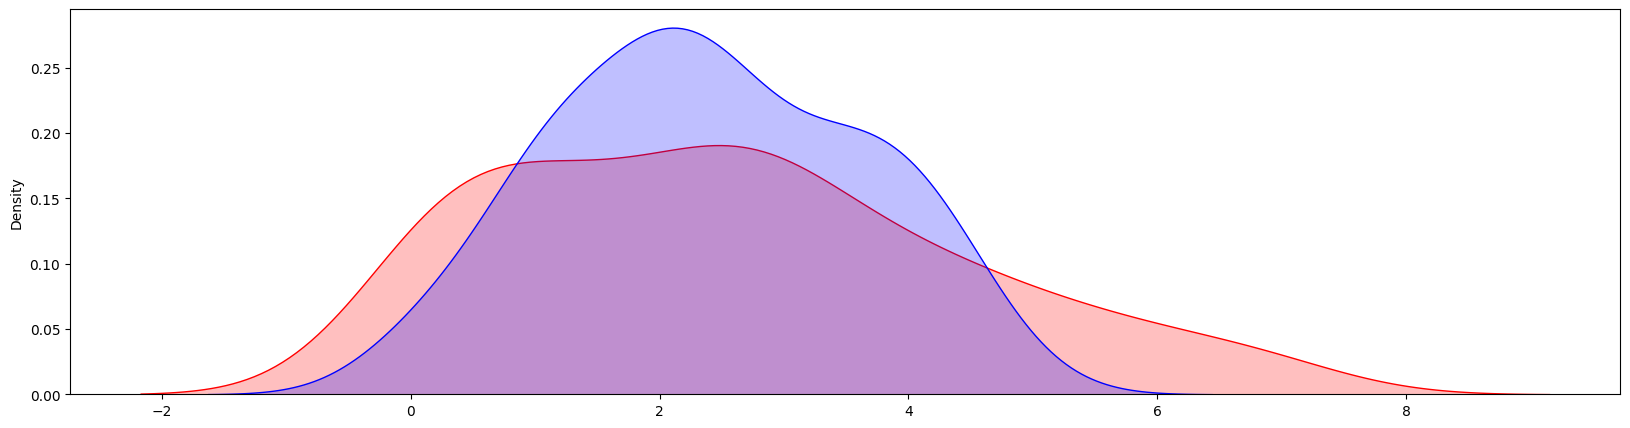

In [17]:
# Get Output variables
hopt = df_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
compute_performance(models_gbr, X, y_hopt)

### Baseline + QY

In [18]:
df_02_PCE = df_filtered_PCE.drop(['mat0', 'mat1', 'hopt (%)'])
df_02_PCE = df_02_PCE.drop_nulls()

total, _ = df_02_PCE.shape
for col in df_02_PCE.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_02_PCE.shape

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


(107, 8)

PCE
Gradient Boosting Regressor   : 0.9364624383243004

Gradient Boosting Regressor   


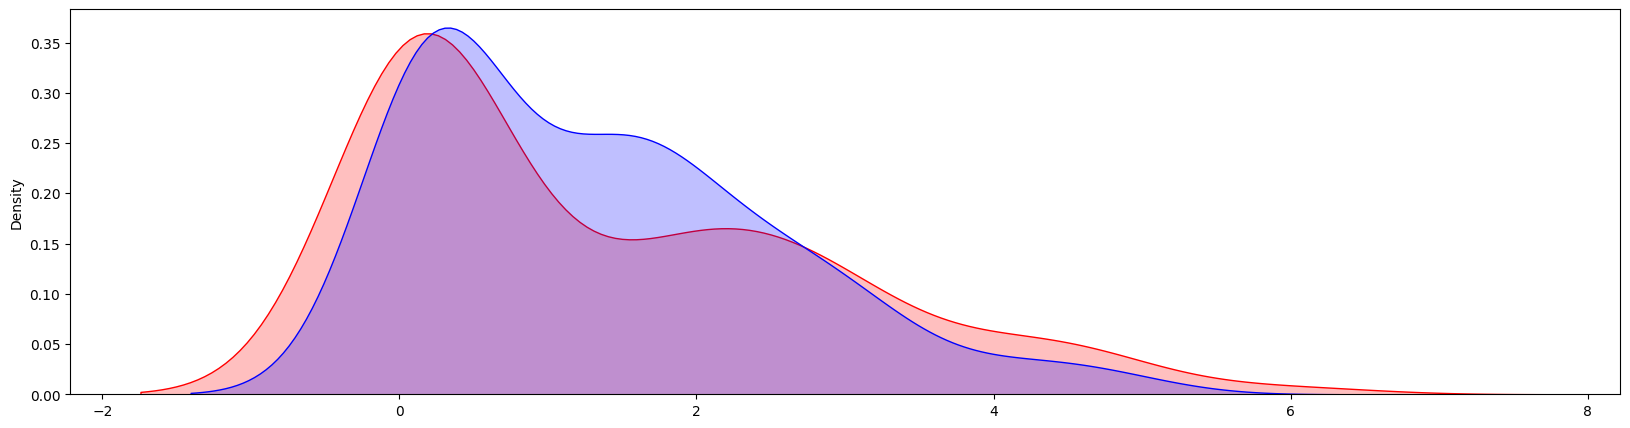

In [19]:
# Get Output variables
PCE = df_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
compute_performance(models_gbr, X, y_PCE)

## Clustering

In [22]:
df_clustering = df.drop(['mat0', 'mat1', 'hopt (%)', 'PCE (%)'])
df_clustering = df_clustering.drop_nulls()

total, _ = df_clustering.shape
for col in df_clustering.get_columns():
    print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

df_clustering.shape

abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%


shape: (173, 7)
┌──────────┬─────────┬─────────┬─────────┬────────┬────────┬────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ em_min ┆ em_max ┆ QY (%) │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---    ┆ ---    │
│ i64      ┆ i64     ┆ i64     ┆ i64     ┆ i64    ┆ i64    ┆ f64    │
╞══════════╪═════════╪═════════╪═════════╪════════╪════════╪════════╡
│ 578      ┆ 420     ┆ 600     ┆ 613     ┆ 550    ┆ 750    ┆ 98.0   │
│ 800      ┆ 400     ┆ 800     ┆ 900     ┆ 700    ┆ 1000   ┆ 30.0   │
│ 600      ┆ 400     ┆ 600     ┆ 630     ┆ 600    ┆ 700    ┆ 50.0   │
│ 376      ┆ 300     ┆ 650     ┆ 623     ┆ 600    ┆ 700    ┆ 50.0   │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ...    ┆ ...    ┆ ...    │
│ 660      ┆ 480     ┆ 680     ┆ 665     ┆ 600    ┆ 800    ┆ 31.0   │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 60.0   │
│ 510      ┆ 250     ┆ 520     ┆ 535     ┆ 400    ┆ 650    ┆ 78.0   │
│ 370      ┆ 250     ┆ 400     ┆ 612     ┆ 570    ┆ 720    ┆ 60.0   │
└──────────┴─────────┴─────────┴─────────┴────────┴────────┴────────┘

In [23]:
import sklearn.metrics as sklearn_metrics

def inertia_score(X, labels):
  """This is the same of scikit-learn's KMeans.inertia_, but it works also in case of only one label."""

  inertia = 0.0
  for label in set(labels):
    X_cluster = X[labels == label, :]
    centroid = np.mean(X_cluster, axis=0)
    inertia += np.sum((X_cluster - centroid) ** 2)
  return inertia


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)


def davies_bouldin_score(X, labels):
  """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.davies_bouldin_score(X, labels)


def silhouette_score(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.silhouette_score(X, labels)


def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

In [24]:
# Cluster the materials without the hopt and PCE
X = df_clustering.to_numpy()

scores = {'elbow': [], 'calinski-harabasz': [], 'davies-bouldin': [], 'silhouette': [], 'bic': [], }

min_k = 2
max_k = 20

for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', init='k-means++', random_state=5).fit(X)
    labels = kmeans.labels_
    scores['elbow'].append(inertia_score(X, labels))
    scores['calinski-harabasz'].append(calinski_harabasz_score(X, labels))
    scores['davies-bouldin'].append(davies_bouldin_score(X, labels))
    scores['silhouette'].append(silhouette_score(X, labels))
    bic, _ = get_bic_aic(k, X)
    scores['bic'].append(bic)

In [25]:
x = range(min_k, max_k)
y = scores['elbow']

points = np.zeros((len(y),2))
points[:,0] = x
points[:,1] = y

#idx = kneedle.auto_knee(points)
#print(f'{idx} {x[idx]}')
# calinski-harabasz higher is better
# davies-bouldin lower is better
# silhouette higher is better
# bic higher is better

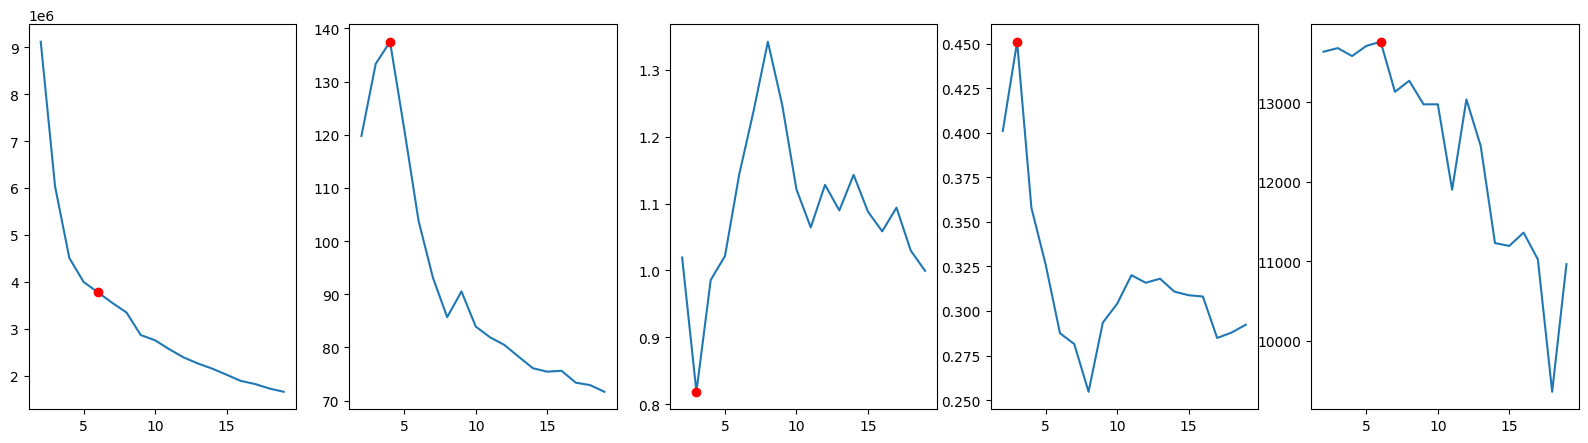

In [26]:
methods = ['elbow', 'calinski-harabasz', 'davies-bouldin', 'silhouette', 'bic']
fig, axs = plt.subplots(1, 5)

for i in range(len(methods)):
    method = methods[i]
    
    axs[i].plot(range(min_k, max_k), scores[method])
    if method == 'elbow':
        idx = kneedle.auto_knee(points)
    elif method == 'calinski-harabasz':
        idx = scores[method].index(max(scores[method]))
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'davies-bouldin':
        idx = scores[method].index(min(scores[method]))
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'silhouette':
        idx = scores[method].index(max(scores[method]))
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'bic':
        idx = scores[method].index(max(scores[method]))
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    axs[i].plot(x[idx], scores[method][idx], 'ro')

## Previous version

In [27]:
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
X

array([[5.78e+02, 4.20e+02, 6.00e+02, ..., 9.80e+01, 1.88e+01, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [3.70e+02, 2.50e+02, 4.00e+02, ..., 6.00e+01, 2.00e-02, 1.98e-04],
       [5.10e+02, 2.50e+02, 5.20e+02, ..., 7.80e+01, 3.50e-02, 1.82e-04],
       [3.70e+02, 2.50e+02, 4.00e+02, ..., 6.00e+01, 4.80e-02, 4.71e-04]])

In [28]:
# Get the Original Values
QY = X.T[6]
hopt = X.T[7]
PCE = X.T[8]

# Get the Masks for the non-zero values
QY_MASK = QY != 0
hopt_MASK = hopt != 0
PCE_MASK = PCE != 0

# Convert boolean mask to index one
QY_MASK = [i for i in range(len(QY_MASK)) if QY_MASK[i]]
hopt_MASK = [i for i in range(len(hopt_MASK)) if hopt_MASK[i]]
PCE_MASK = [i for i in range(len(PCE_MASK)) if PCE_MASK[i]]

# Compute the average and standard deviation
QY_AVG = np.average(QY[QY_MASK])
QY_STD = np.std(QY[QY_MASK])

hopt_AVG = np.average(hopt[hopt_MASK])
hopt_STD = np.std(hopt[hopt_MASK])

PCE_AVG = np.average(PCE[PCE_MASK])
PCE_STD = np.std(PCE[PCE_MASK])

test = .3
random.seed(42)

# Select the index of the test set
QY_TEST_SET_INDEX = random.sample(QY_MASK, int(len(QY_MASK)*test))
hopt_TEST_SET_INDEX = random.sample(hopt_MASK, int(len(hopt_MASK)*test))
PCE_TEST_SET_INDEX = random.sample(PCE_MASK, int(len(PCE_MASK)*test))

print(f'{QY_TEST_SET_INDEX}\n{hopt_TEST_SET_INDEX}\n{PCE_TEST_SET_INDEX}')

[192, 42, 13, 95, 86, 80, 52, 38, 168, 33, 180, 135, 15, 14, 35, 77, 83, 156, 183, 199, 172, 71, 193, 134, 78, 141, 96, 7, 59, 190, 112, 175, 56, 186, 111, 194, 187, 123, 36, 116, 113, 92, 18, 144, 47, 122, 17, 198, 54, 133, 105]
[143, 83, 22, 14, 93, 123, 31, 94, 38, 149, 116, 171, 144, 59, 145, 141, 87, 136, 50, 140, 177, 138, 133, 12, 127, 131, 32, 106, 189, 44, 195, 194, 81, 183, 176, 139, 191, 41, 180, 188, 150, 151, 10]
[111, 27, 176, 81, 99, 75, 200, 60, 189, 137, 185, 163, 198, 194, 155, 119, 98, 148, 201, 47, 74, 46, 72, 168, 135, 129, 181, 178, 139, 103, 173, 197, 93, 61, 180, 124, 186, 30]


In [29]:
# Store original values from the test set
QY_TEST_SET = QY[QY_TEST_SET_INDEX]
hopt_TEST_SET = hopt[hopt_TEST_SET_INDEX]
PCE_TEST_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_TEST_SET}\n{hopt_TEST_SET}\n{PCE_TEST_SET}')

# Replace the test set with zeros
QY[QY_TEST_SET_INDEX] = 0
hopt[hopt_TEST_SET_INDEX] = 0
PCE[PCE_TEST_SET_INDEX] = 0

print(f'{QY[QY_TEST_SET_INDEX]}\n{hopt[hopt_TEST_SET_INDEX]}\n{PCE[PCE_TEST_SET_INDEX]}')

[ 57.    94.    11.    85.    40.    17.    25.    36.2   15.01  80.
  11.    67.    45.     9.    40.    70.    30.5   35.    59.    60.
  91.    24.    68.    70.    95.    15.7   78.    30.    78.    68.
  60.    44.    81.    54.    10.    65.     4.    93.    63.    86.
  95.    61.   100.    32.7   70.    20.    40.8   31.    35.9   40.
  12.  ]
[2.900e+00 3.400e-01 2.500e-01 5.000e-01 4.300e-01 5.400e+01 2.900e-01
 1.000e-02 2.950e+00 1.360e+00 4.800e+01 2.700e+00 1.000e+00 6.400e+00
 4.560e+00 3.200e+00 4.300e+00 3.770e+01 2.400e+00 1.900e+01 1.310e+01
 5.800e-02 1.600e+00 2.600e+00 6.880e+00 5.840e+00 1.040e+01 7.000e-01
 9.112e+00 9.200e-01 1.600e-01 1.500e-01 2.470e+00 1.070e+01 7.700e+00
 1.700e+00 5.710e+00 1.200e+01 1.280e+01 5.710e+00 3.080e+00 2.550e+00
 3.000e-01]
[2.10000000e+00 5.40000000e-01 5.80000000e-02 1.90000000e-01
 4.41000000e-02 2.80000000e-01 1.82000000e-04 3.27000000e+00
 2.32000000e+00 1.80000000e-01 1.42000000e-01 3.80000000e+00
 2.10000000e-01 4.9412608

In [30]:
# Write on the X Matrix again
X.T[6] = QY
X.T[7] = hopt
X.T[8] = PCE

In [31]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, W, H, cost = nmf.nmf_mu(X, k=k, seed=s)
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [32]:
print(f"{cost} {solution}")

168.87254218525462 (8, 89)


In [33]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 52.75492159  26.56204998  69.75273613  10.74294422  27.26189869
  31.59122822  20.69144021  28.54907763  37.57054888  61.76929697
  40.5282151   37.43574071  40.02176247  55.43586652  39.5893202
  98.58234588  37.65023012  16.28498916  69.62638243  45.27982081
  33.02422583  58.02104583  48.88890307  74.10408524  44.97379758
  41.9574339   21.10344786  68.81574406  60.31944004  48.97515403
 105.31622389  86.6239676   29.03507097  46.02353758  29.83210296
  60.89315174  92.28594757  29.30970785  72.62626397  82.80301104
  35.68426235  34.8019657   25.45406985  23.0271307   35.67192001
  40.72439307  23.42133801  85.80368084  68.46225679  43.80395752
  75.23224301]
[6.68393744 3.11776151 4.59715816 7.91449795 6.25908257 5.48413797
 6.9968854  4.98869513 5.84422142 6.25197643 4.52498077 1.88932873
 4.12672602 4.79128875 5.41425208 6.47737942 5.52378389 5.72860598
 4.92732766 7.8509413  6.06607355 5.40529516 6.59960791 7.18002425
 7.26906036 3.88247157 3.39783404 3.97509681 7.04692129 5.

In [34]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 37.74317562203985 (51.10491329479768 ± 26.800503287019982)
RMSE(HOPT): 11.898391672869852 (6.083229166666666 ± 8.376054112533762)
RMSE(PCE): 1.6561557969831817 (1.96654010364438 ± 2.5334611293201497)


### Grid Search (optimize with test set)

In [35]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, _, _, _ = nmf.nmf_mu(X, k=k, seed=s)
        # Get the values with the mask
        hopt = Xr.T[7]
        PCE = Xr.T[8]
        hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
        PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]
        # Compute the cost of the test set
        rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
        rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))
        #cost = rmse_hopt + rmse_PCE
        #cost = rmse_hopt
        cost = rmse_PCE
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [36]:
print(f"{cost} {solution}")

1.604042057770969 (8, 97)


In [37]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 51.47152285  48.43260394  48.58984698  19.05819395  31.43967537
  86.28623808  64.54943049  36.24882781  50.69621082  30.07565495
  67.12192022  36.06055573  63.49556777  22.27780388 124.43817009
  48.66927053  41.30873693  48.34261205  38.10013118  34.30033798
  40.00796901  35.40313073  62.96616103  36.05796663  47.89166439
  34.92861904  75.68078916  43.23437315  88.93341658  59.95726335
  34.66838666  60.89363653  67.1437458   83.67772009  63.46389228
  39.96040621 129.50013149  44.32737671  28.90150781  37.60431
  78.10959549  51.42013479  57.75378085  18.75260311  34.33571998
  23.16160173  41.17062561  61.91276302  41.79659978  61.38634478
  90.31809846]
[ 5.96109653  4.81219838  5.08907069  3.72959222  4.09825081  5.3769692
  7.28550048  5.60627908  4.2309338   4.77747044  2.83011096  3.41530388
  2.81093804 11.95813236  6.13266067  3.68570866  4.77921197  7.52234477
  3.68424852  5.0349515   2.46151866  8.73755076  5.68792274  5.94224047
  3.80839897  4.15104379  5.70805328 

In [38]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 38.82212741922641 (51.10491329479768 ± 26.800503287019982)
RMSE(HOPT): 12.163722444822383 (6.083229166666666 ± 8.376054112533762)
RMSE(PCE): 1.604042057770969 (1.96654010364438 ± 2.5334611293201497)


### Reconstruct the matrix

In [39]:
# Get the original matrix
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
print(X.shape)

# Get the reconstructed matrix
Xr, _, _, _ = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Replace all zeros with reconstructed values
X[X==0] = Xr[X==0]

(202, 9)


In [40]:
X

array([[5.78000000e+02, 4.20000000e+02, 6.00000000e+02, ...,
        9.80000000e+01, 1.88000000e+01, 3.31469708e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        2.62862223e+01, 3.60919415e+00, 1.63152701e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        3.29902088e+01, 4.11993717e+00, 1.52383393e+00],
       ...,
       [3.70000000e+02, 2.50000000e+02, 4.00000000e+02, ...,
        6.00000000e+01, 2.00000000e-02, 1.98000000e-04],
       [5.10000000e+02, 2.50000000e+02, 5.20000000e+02, ...,
        7.80000000e+01, 3.50000000e-02, 1.82000000e-04],
       [3.70000000e+02, 2.50000000e+02, 4.00000000e+02, ...,
        6.00000000e+01, 4.80000000e-02, 4.71000000e-04]])

In [41]:
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])
_, cols = X.shape
field_names = df.columns
print(f'{field_names}')
df = pl.DataFrame({field_names[i+2]: X[:,i] for i in range(cols)})
df

['mat0', 'mat1', 'abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']


shape: (202, 9)
┌──────────┬─────────┬─────────┬─────────┬─────┬────────┬───────────┬──────────┬──────────┐
│ abs_peak ┆ abs_min ┆ abs_max ┆ em_peak ┆ ... ┆ em_max ┆ QY (%)    ┆ hopt (%) ┆ PCE (%)  │
│ ---      ┆ ---     ┆ ---     ┆ ---     ┆     ┆ ---    ┆ ---       ┆ ---      ┆ ---      │
│ f64      ┆ f64     ┆ f64     ┆ f64     ┆     ┆ f64    ┆ f64       ┆ f64      ┆ f64      │
╞══════════╪═════════╪═════════╪═════════╪═════╪════════╪═══════════╪══════════╪══════════╡
│ 578.0    ┆ 420.0   ┆ 600.0   ┆ 613.0   ┆ ... ┆ 750.0  ┆ 98.0      ┆ 18.8     ┆ 3.314697 │
│ 540.0    ┆ 400.0   ┆ 600.0   ┆ 590.0   ┆ ... ┆ 690.0  ┆ 26.286222 ┆ 3.609194 ┆ 1.631527 │
│ 540.0    ┆ 400.0   ┆ 600.0   ┆ 590.0   ┆ ... ┆ 690.0  ┆ 32.990209 ┆ 4.119937 ┆ 1.523834 │
│ 730.0    ┆ 600.0   ┆ 900.0   ┆ 910.0   ┆ ... ┆ 1000.0 ┆ 85.66069  ┆ 2.5      ┆ 2.813018 │
│ ...      ┆ ...     ┆ ...     ┆ ...     ┆ ... ┆ ...    ┆ ...       ┆ ...      ┆ ...      │
│ 660.0    ┆ 480.0   ┆ 680.0   ┆ 665.0   ┆ ... ┆ 800.0  ┆ 31.0      ┆ 2.65     ┆ 0.21     │
│ 370.0    ┆ 250.0   ┆ 400.0   ┆ 612.0   ┆ ... ┆ 720.0  ┆ 60.0      ┆ 0.02     ┆ 0.000198 │
│ 510.0    ┆ 250.0   ┆ 520.0   ┆ 535.0   ┆ ... ┆ 650.0  ┆ 78.0      ┆ 0.035    ┆ 0.000182 │
│ 370.0    ┆ 250.0   ┆ 400.0   ┆ 612.0   ┆ ... ┆ 720.0  ┆ 60.0      ┆ 0.048    ┆ 0.000471 │
└──────────┴─────────┴─────────┴─────────┴─────┴────────┴───────────┴──────────┴──────────┘